In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib notebook
from argparse import ArgumentParser
import yaml
import os
import math
import torch
from torch.utils.data import DataLoader

import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP
# from torch import vmap
from functorch import vmap, grad
from models import FNN2d, FNN3d
from train_utils import Adam

from solver.BurgersEq import BurgersEq2D_Vec
import scipy.io
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import traceback
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from tqdm import tqdm
from train_utils.utils import save_checkpoint, get_grid3d, load_checkpoint, load_config, update_config
from train_utils.losses import LpLoss
from train_utils.datasets import DataLoader2D_coupled
from solver.my_random_fields import GRF_Mattern
from importlib import reload


import imageio

try:
    import wandb
except ImportError:
    wandb = None


# Define Loss for Fourier Derivatives

In [2]:
def FDM_Burgers2D_Vec(u, v, D=1, nu=0.01):
    batchsize = u.size(0)
    nx = u.size(1)
    ny = u.size(2)
    nt = u.size(3)
    u = u.reshape(batchsize, nx, ny, nt)
    v = v.reshape(batchsize, nx, ny, nt)
    dt = D / (nt-1)
    dx = D / (nx)
#     u2 = u**2
    u_h = torch.fft.fftn(u, dim=[1, 2])
    v_h = torch.fft.fftn(v, dim=[1, 2])
#     u2_h = torch.fft.fftn(u2, dim=[1, 2])
    # Wavenumbers in y-direction
    k_max = nx//2
    N = nx
    k_x = torch.cat((torch.arange(start=0, end=k_max, step=1, device=device),
                     torch.arange(start=-k_max, end=0, step=1, device=device)), 0).reshape(N, 1).repeat(1, N).reshape(1,N,N,1)
    k_y = torch.cat((torch.arange(start=0, end=k_max, step=1, device=device),
                     torch.arange(start=-k_max, end=0, step=1, device=device)), 0).reshape(1, N).repeat(N, 1).reshape(1,N,N,1)
    ux_h = 2j *np.pi*k_x*u_h
    uxx_h = 2j *np.pi*k_x*ux_h
    uy_h = 2j *np.pi*k_y*u_h
    uyy_h = 2j *np.pi*k_y*uy_h
    
    vx_h = 2j *np.pi*k_x*v_h
    vxx_h = 2j *np.pi*k_x*vx_h
    vy_h = 2j *np.pi*k_y*v_h
    vyy_h = 2j *np.pi*k_y*vy_h
    
    ux = torch.fft.irfftn(ux_h[:, :, :k_max+1], dim=[1, 2])
    uy = torch.fft.irfftn(uy_h[:, :, :k_max+1], dim=[1, 2])
    uxx = torch.fft.irfftn(uxx_h[:, :, :k_max+1], dim=[1, 2])
    uyy = torch.fft.irfftn(uyy_h[:, :, :k_max+1], dim=[1, 2])
    ut = (u[..., 2:] - u[..., :-2]) / (2 * dt)
    
    vx = torch.fft.irfftn(vx_h[:, :, :k_max+1], dim=[1, 2])
    vy = torch.fft.irfftn(vy_h[:, :, :k_max+1], dim=[1, 2])
    vxx = torch.fft.irfftn(vxx_h[:, :, :k_max+1], dim=[1, 2])
    vyy = torch.fft.irfftn(vyy_h[:, :, :k_max+1], dim=[1, 2])
    vt = (v[..., 2:] - v[..., :-2]) / (2 * dt)
#     utt = (u[..., 2:] - 2.0*u[..., 1:-1] + u[..., :-2]) / (dt**2)
#     Du = ut + (0.5*(u2x + u2y) - nu*(uxx + uyy))[..., 1:-1]
    Du = ut + (u*ux + v*uy - nu*(uxx + uyy))[..., 1:-1]
    Dv = vt + (u*vx + v*vy - nu*(vxx + vyy))[..., 1:-1]
#     Du = ut + (u*(ux + uy) - nu*(uxx + uyy))[..., 1:-1]
    return Du, Dv


def PINO_loss_burgers2D_vec(s, s0, nu=0.01):
    batchsize = s.size(0)
    nx = s.size(1)
    ny = s.size(2)
    nt = s.size(3)
    s = s.reshape(batchsize, nx, ny, nt, 2)

    lploss = LpLoss(size_average=True)
    s_ic = s[..., 0, :].reshape(s0.shape)
    loss_ic = lploss(s_ic, s0)
#     index_t = torch.zeros(nx,).long()
#     index_x = torch.tensor(range(nx)).long()
#     boundary_u = u[:, index_t, index_x]
#     loss_u = F.mse_loss(boundary_u, u0)

#     Du = FDM_Burgers(u, nu=nu)[:, :, :, :]
    u = s[..., 0]
    v = s[..., 1]
    Du, Dv = FDM_Burgers2D_Vec(u, v, nu=nu)
    Ds = torch.stack([Du, Dv], dim=-1)
    f = torch.zeros(Ds.shape, device=s.device)
    loss_f = F.mse_loss(Ds, f)

    # loss_bc0 = F.mse_loss(u[:, :, 0], u[:, :, -1])
    # loss_bc1 = F.mse_loss((u[:, :, 1] - u[:, :, -1]) /
    #                       (2/(nx)), (u[:, :, 0] - u[:, :, -2])/(2/(nx)))
    return loss_ic, loss_f

# Define Training Fuction

In [3]:
def train_burgers2d_vec(model,
                 dataset,
                 train_loader,
                 optimizer, scheduler,
                 config,
                 nu=0.01,
                 rank=0, log=False,
                 project='PINO-2d-default',
                 group='default',
                 tags=['default'],
                 use_tqdm=True):
    if rank == 0 and wandb and log:
        run = wandb.init(project=project,
                         entity='shawngr2',
                         group=group,
                         config=config,
                         tags=tags, reinit=True,
                         settings=wandb.Settings(start_method="fork"))

    data_weight = config['train']['xy_loss']
    f_weight = config['train']['f_loss']
    ic_weight = config['train']['ic_loss']
    ckpt_freq = config['train']['ckpt_freq']
    nfields = config['model']['out_dim']
#     nfields = model.out_dim
    model.train()
    myloss = LpLoss(size_average=True)
    S, T = dataset.S, dataset.T
    pbar = range(config['train']['epochs'])
    if use_tqdm:
        pbar = tqdm(pbar, dynamic_ncols=True, smoothing=0.1)

    for e in pbar:
        model.train()
        train_pino = 0.0
        train_ic = 0.0
        data_l2 = 0.0
        train_loss = 0.0
        

        for x, y in train_loader:
            x, y = x.to(rank), y.to(rank)
            out = model(x).reshape(y.shape)
            data_loss = myloss(out, y)
#             u0 = x[..., 0, -2]
#             v0 = x[..., 0, -1]
#             s0 = x[..., 0, -2:]
            s0 = x[..., 0, -nfields:]
            loss_ic, loss_f = PINO_loss_burgers2D_vec(out, s0, nu=nu)
            total_loss = loss_ic * ic_weight + loss_f * f_weight + data_loss * data_weight

            optimizer.zero_grad()

            total_loss.backward()
            optimizer.step()
            data_l2 += data_loss.item()
            train_pino += loss_f.item()
            train_ic += loss_ic.item()
            train_loss += total_loss.item()
        scheduler.step()
        data_l2 /= len(train_loader)
        train_pino /= len(train_loader)
        train_ic /= len(train_loader)
        train_loss /= len(train_loader)
        if use_tqdm:
            pbar.set_description(
                (
                    f'Epoch {e}, train loss: {train_loss:.5f} '
                    f'train f error: {train_pino:.5f}; '
                    f'data l2 error: {data_l2:.5f}; '
                    f'train ic error: {train_ic:.5f}'
                )
            )
        if wandb and log:
            wandb.log(
                {
                    'Train f error': train_pino,
                    'Train L2 error': data_l2,
                    'Train ic error': loss_ic,
                    'Train loss': train_loss,
                }
            )

        if e % ckpt_freq == 0:
            save_checkpoint(config['train']['save_dir'],
                            config['train']['save_name'].replace('.pt', f'_{e}.pt'),
                            model, optimizer)
    save_checkpoint(config['train']['save_dir'],
                    config['train']['save_name'],
                    model, optimizer)
    print('Done!')

In [4]:
def train_burgers2d_vec_pad(model,
                             dataset,
                             train_loader,
                             optimizer, scheduler,
                             config,
                             nu=0.01, padding=0,
                             rank=0, log=False,
                             project='PINO-2d-default',
                             group='default',
                             tags=['default'],
                             use_tqdm=True):
    if rank == 0 and wandb and log:
        run = wandb.init(project=project,
                         entity='shawngr2',
                         group=group,
                         config=config,
                         tags=tags, reinit=True,
                         settings=wandb.Settings(start_method="fork"))

    data_weight = config['train']['xy_loss']
    f_weight = config['train']['f_loss']
    ic_weight = config['train']['ic_loss']
    ckpt_freq = config['train']['ckpt_freq']
    nfields = config['model']['out_dim']
#     nfields = model.out_dim
    model.train()
    myloss = LpLoss(size_average=True)
    S, T = dataset.S, dataset.T
    batch_size = config['train']['batchsize']
    pbar = range(config['train']['epochs'])
    if use_tqdm:
        pbar = tqdm(pbar, dynamic_ncols=True, smoothing=0.1)

    for e in pbar:
        model.train()
        train_pino = 0.0
        train_ic = 0.0
        data_l2 = 0.0
        train_loss = 0.0
        

        for x, y in train_loader:
            x, y = x.to(rank), y.to(rank)
            x_in = F.pad(x, (0, 0, 0, padding), "constant", 0)
            out = model(x_in).reshape(batch_size, S, S, T + padding, nfields)
            out = out[..., :-padding, :]
            s0 = x[..., 0, -nfields:]
            
#             out = model(x).reshape(y.shape)
            data_loss = myloss(out, y)
            
            loss_ic, loss_f = PINO_loss_burgers2D_vec(out, s0, nu=nu)
            total_loss = loss_ic * ic_weight + loss_f * f_weight + data_loss * data_weight

            optimizer.zero_grad()

            total_loss.backward()
            optimizer.step()
            data_l2 += data_loss.item()
            train_pino += loss_f.item()
            train_ic += loss_ic.item()
            train_loss += total_loss.item()
        scheduler.step()
        data_l2 /= len(train_loader)
        train_pino /= len(train_loader)
        train_ic /= len(train_loader)
        train_loss /= len(train_loader)
        if use_tqdm:
            pbar.set_description(
                (
                    f'Epoch {e}, train loss: {train_loss:.5f} '
                    f'train f error: {train_pino:.5f}; '
                    f'data l2 error: {data_l2:.5f}; '
                    f'train ic error: {train_ic:.5f}'
                )
            )
        if wandb and log:
            wandb.log(
                {
                    'Train f error': train_pino,
                    'Train L2 error': data_l2,
                    'Train ic error': loss_ic,
                    'Train loss': train_loss,
                }
            )

        if e % ckpt_freq == 0:
            save_checkpoint(config['train']['save_dir'],
                            config['train']['save_name'].replace('.pt', f'_{e}.pt'),
                            model, optimizer)
    save_checkpoint(config['train']['save_dir'],
                    config['train']['save_name'],
                    model, optimizer)
    print('Done!')

# Define Eval Function

In [1]:
def eval_burgers2D_vec(model,
                dataloader,
                config,
                device,
                nu=0.01,
                use_tqdm=True):
    model.eval()
    nfields = config['model']['out_dim']
#     nfields = model.out_dim
    myloss = LpLoss(size_average=True)
    if use_tqdm:
        pbar = tqdm(dataloader, dynamic_ncols=True, smoothing=0.05)
    else:
        pbar = dataloader

    test_err = []
    f_err = []
    with torch.no_grad():
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            out = model(x).reshape(y.shape)
            data_loss = myloss(out, y)
            s0 = x[..., 0, -nfields:]
            loss_ic, f_loss = PINO_loss_burgers2D_vec(out, s0, nu=nu)
            test_err.append(data_loss.item())
            f_err.append(f_loss.item())

    mean_f_err = np.mean(f_err)
    std_f_err = np.std(f_err, ddof=1) / np.sqrt(len(f_err))

    mean_err = np.mean(test_err)
    std_err = np.std(test_err, ddof=1) / np.sqrt(len(test_err))

    print(f'==Averaged relative L2 error mean: {mean_err}, std error: {std_err}==\n'
          f'==Averaged equation error mean: {mean_f_err}, std error: {std_f_err}==')



In [2]:
def eval_burgers2D_vec_pad(model,
                       dataloader,
                       config,
                       device,
                       nu=0.01, padding=0,
                       use_tqdm=True):
    model.eval()
    nfields = config['model']['out_dim']
#     nfields = model.nfields
    myloss = LpLoss(size_average=True)
    if use_tqdm:
        pbar = tqdm(dataloader, dynamic_ncols=True, smoothing=0.05)
    else:
        pbar = dataloader

    test_err = []
    f_err = []
    
    with torch.no_grad():
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            batch_size, S, S, T, nfields = y.shape
            x_in = F.pad(x, (0, 0, 0, padding), "constant", 0)
            out = model(x_in).reshape(batch_size, S, S, T + padding, nfields)
            out = out[..., :-padding, :]
            s0 = x[..., 0, -nfields:]
            
#             out = model(x).reshape(y.shape)
            data_loss = myloss(out, y)
            
            loss_ic, loss_f = PINO_loss_burgers2D_vec(out, s0, nu=nu)
#             total_loss = loss_ic * ic_weight + loss_f * f_weight + data_loss * data_weight

#             out = model(x).reshape(y.shape)
#             data_loss = myloss(out, y)

#             loss_ic, f_loss = PINO_loss_burgers2D(out, x[..., 0, -1], nu=nu)
            test_err.append(data_loss.item())
            f_err.append(loss_f.item())

    mean_f_err = np.mean(f_err)
    std_f_err = np.std(f_err, ddof=1) / np.sqrt(len(f_err))

    mean_err = np.mean(test_err)
    std_err = np.std(test_err, ddof=1) / np.sqrt(len(test_err))

    print(f'==Averaged relative L2 error mean: {mean_err}, std error: {std_err}==\n'
          f'==Averaged equation error mean: {mean_f_err}, std error: {std_f_err}==')



# Define Parameters

In [7]:
dim = 2
N = 128
Nx = N
Ny = N
l = 0.1
L = 1.0
sigma = 0.2 # 2.0
nu = 0.01
Nu = None #2.0
Nsamples = 500
jitter = 1e-12
dt = 1.0e-4
save_int = int(1e-2/dt)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Generate Random Fields

In [8]:
grf = GRF_Mattern(dim, N, length=L, nu=Nu, l=l, sigma=sigma, boundary="periodic", device=device)
U0 = grf.sample(Nsamples)
V0 = grf.sample(Nsamples)

In [9]:
U0.std()

tensor(0.0459, device='cuda:0')

In [10]:
V0.std()

tensor(0.0457, device='cuda:0')

In [11]:
u0 = U0[0].cpu()
u0

tensor([[-0.0253, -0.0348, -0.0439,  ...,  0.0025, -0.0064, -0.0157],
        [-0.0281, -0.0377, -0.0469,  ...,  0.0002, -0.0088, -0.0183],
        [-0.0310, -0.0406, -0.0498,  ..., -0.0026, -0.0116, -0.0212],
        ...,
        [-0.0185, -0.0270, -0.0351,  ...,  0.0061, -0.0017, -0.0100],
        [-0.0205, -0.0294, -0.0379,  ...,  0.0055, -0.0028, -0.0115],
        [-0.0228, -0.0320, -0.0409,  ...,  0.0042, -0.0043, -0.0134]])

In [12]:
v0 = V0[0].cpu()
v0

tensor([[0.0692, 0.0666, 0.0635,  ..., 0.0735, 0.0727, 0.0712],
        [0.0676, 0.0655, 0.0629,  ..., 0.0711, 0.0705, 0.0693],
        [0.0654, 0.0636, 0.0616,  ..., 0.0679, 0.0676, 0.0667],
        ...,
        [0.0703, 0.0664, 0.0619,  ..., 0.0773, 0.0758, 0.0735],
        [0.0704, 0.0669, 0.0629,  ..., 0.0765, 0.0753, 0.0732],
        [0.0701, 0.0670, 0.0635,  ..., 0.0753, 0.0743, 0.0725]])

In [18]:
u0.shape
v0.shape

torch.Size([128, 128])

# Plot Random Fields

In [19]:
key = 1
x = torch.linspace(0, 1, Nx + 1)[:-1]
y = torch.linspace(0, 1, Nx + 1)[:-1]
X, Y = torch.meshgrid(x, y, indexing='ij')
u0 = U0[key].cpu().numpy()
v0 = V0[key].cpu().numpy()
u0, v0

(array([[-0.04455311, -0.04495871, -0.04518688, ..., -0.04204297,
         -0.04310181, -0.04393928],
        [-0.04185476, -0.04269709, -0.04331778, ..., -0.03791676,
         -0.03945554, -0.04077424],
        [-0.03882691, -0.04008149, -0.04106794, ..., -0.03351368,
         -0.03551902, -0.03730118],
        ...,
        [-0.05004759, -0.04898469, -0.04785881, ..., -0.05214119,
         -0.05168378, -0.05096938],
        [-0.0487052 , -0.04815748, -0.04751175, ..., -0.04921363,
         -0.04927337, -0.04909336],
        [-0.04685655, -0.04679891, -0.04660513, ..., -0.04582881,
         -0.04639445, -0.04673226]], dtype=float32),
 array([[0.06846873, 0.06467839, 0.06079683, ..., 0.07763727, 0.07511226,
         0.07200243],
        [0.07578215, 0.07243305, 0.06892617, ..., 0.08335662, 0.08139404,
         0.07882033],
        [0.08228548, 0.07938382, 0.0762611 , ..., 0.08827879, 0.08686803,
         0.08482647],
        ...,
        [0.04309174, 0.03807987, 0.03317799, ..., 0.05683

<IPython.core.display.Javascript object>


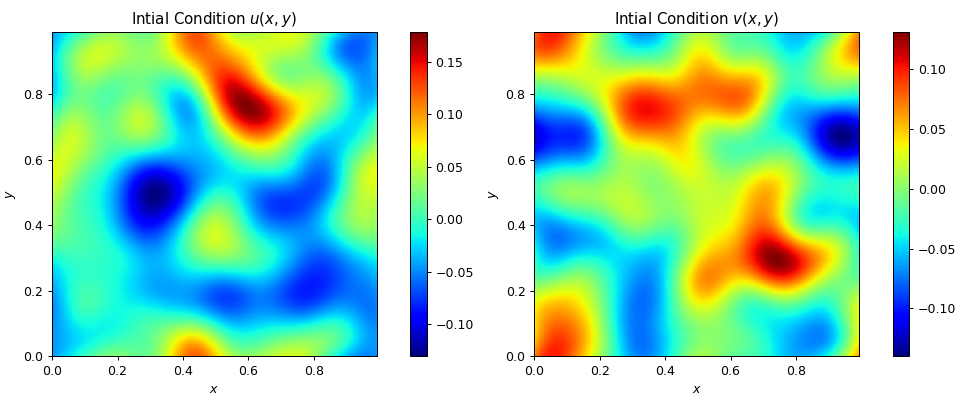

In [20]:
# fig = plt.figure()
# ax = fig.add_subplot(111)

# # fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# # surf = ax.plot_surface(X, Y, u0, cmap='jet', linewidth=0, antialiased=True, vmin=-2, vmax=2)
# c = plt.pcolormesh(X, Y, u0, cmap='jet', shading='gouraud')

# # fig.colorbar(surf, shrink=0.5, aspect=5)
# fig.colorbar(c)

# plt.title('GRF 2D')
# plt.axis('square')
# plt.show()

fig = plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.pcolormesh(X, Y, u0, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Intial Condition $u(x,y)$')
plt.tight_layout()
plt.axis('square')

plt.subplot(1,2,2)
plt.pcolormesh(X, Y, v0, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Intial Condition $v(x,y)$')
plt.tight_layout()
plt.axis('square')
plt.show()

<IPython.core.display.Javascript object>


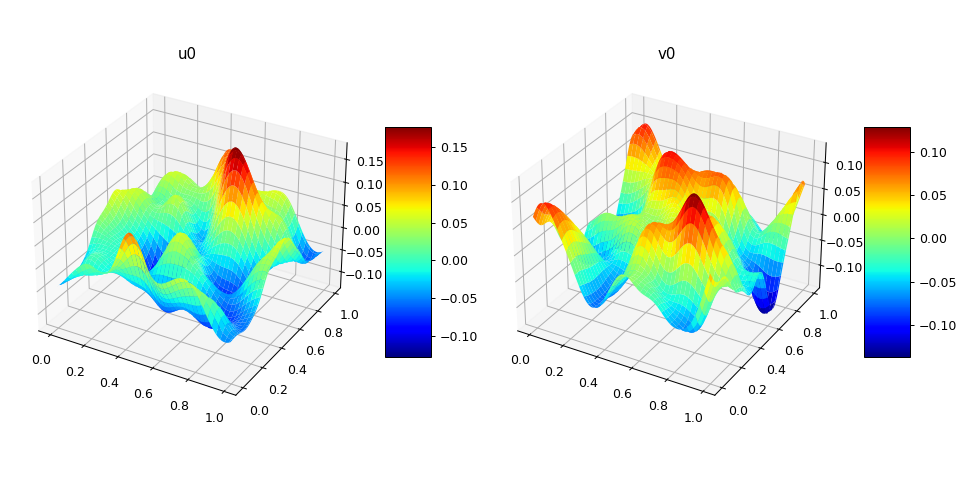

In [21]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6), subplot_kw={"projection": "3d"})
surf1 = ax1.plot_surface(X, Y, u0, cmap='jet', linewidth=0, antialiased=True,)
# plt.colorbar(surf1, shrink=0.5, aspect=5)
plt.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)
ax1.set_title('u0')
surf2 = ax2.plot_surface(X, Y, v0, cmap='jet', linewidth=0, antialiased=True,)
plt.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)
ax2.set_title('v0')
plt.tight_layout()


plt.show()



# Evolve the Couple Burgers Equation

In [14]:
burgers_eq = BurgersEq2D_Vec(Nx=Nx, Ny=Ny, dt=dt, nu=nu, device=device)
U, V = vmap(burgers_eq.burgers_driver, in_dims=(0, 0, None))(U0, V0, save_int)

RuntimeError: CUDA out of memory. Tried to allocate 3.08 GiB (GPU 0; 15.78 GiB total capacity; 9.46 GiB already allocated; 663.75 MiB free; 9.49 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [15]:
U = U.cpu()
V = V.cpu()
torch.cuda.empty_cache()

NameError: name 'U' is not defined

In [24]:
burgers_eq.U = []
burgers_eq.V = []
torch.cuda.empty_cache()

In [25]:
torch.cuda.empty_cache()

In [26]:
au = U0.cpu().float()
u = U.cpu().float()
av = V0.cpu().float()
v = V.cpu().float()
display(u.shape,au.shape)
display(v.shape,av.shape)

torch.Size([500, 101, 128, 128])

torch.Size([500, 128, 128])

torch.Size([500, 101, 128, 128])

torch.Size([500, 128, 128])

# Plot Data

<IPython.core.display.Javascript object>


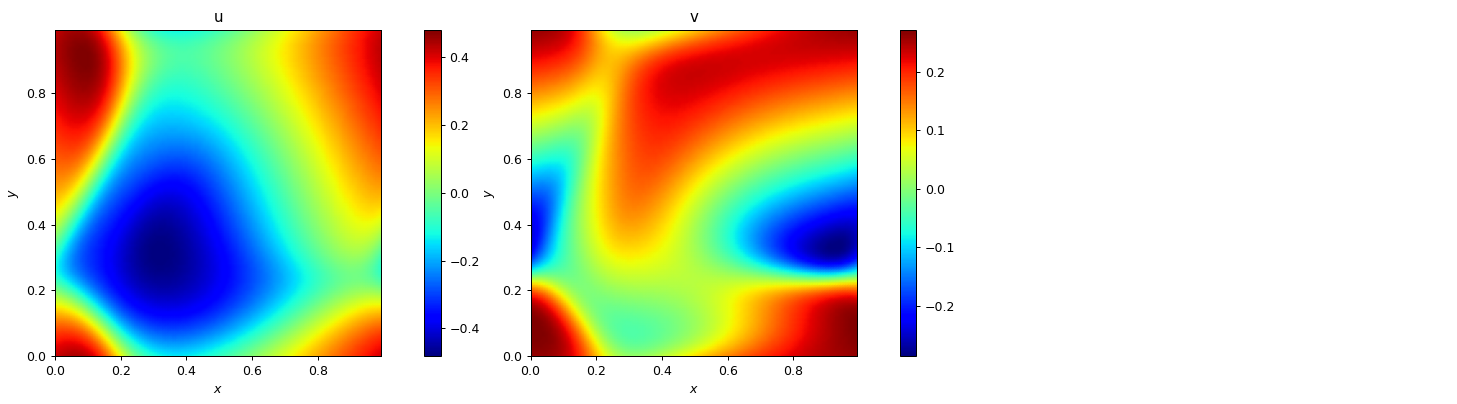

In [27]:
# %matplotlib notebook
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))

plt.ion()
ax3.axis('off')


fig.show()
fig.canvas.draw()


x = torch.linspace(0, 1, Nx + 1)[:-1]
y = torch.linspace(0, 1, Nx + 1)[:-1]
X, Y = torch.meshgrid(x, y, indexing='ij')
# u = U[key].cpu().numpy()
# u0
# pcm1 = ax1.plot_pcmace(X, Y, true[..., 0], cmap='jet', label='true', alpha=1.0, rstride=1, cstride=1, linewidth=0.0, antialiased=False)
pcm1 = ax1.pcolormesh(X, Y, u[key, -1], cmap='jet', label='u', shading='gouraud')

# plt.colorbar()
# pcm2 = ax2.plot_pcmace(X, Y, pred[..., 0], cmap='jet', label='pred', alpha=1.0, rstride=1, cstride=1, linewidth=0.0, antialiased=False)
pcm2 = ax2.pcolormesh(X, Y, v[key, -1], cmap='jet', label='v', shading='gouraud')

# pcm = ax.pcolormesh(X, Y, u[0], vmin=-0.5, vmax=0.5, cmap='jet', shading='gouraud')
# divider = make_axes_locatable(ax2)
# cax = divider.append_axes("right", size="5%", pad=0.05)


# fig.colorbar(pcm, shrink=0.5, aspect=5)

# ax.
# ax.set_clim(-1, 1)
# display(ax.get_clim())
clim1 = pcm1.get_clim()
pcm1.set_clim(clim1)
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')

clim2 = pcm2.get_clim()
pcm2.set_clim(clim2)
ax2.set_xlabel('$x$')
ax2.set_ylabel('$y$')

ax1.set_title(f'u')
ax2.set_title(f'v')

# plt.axis('square')

plt.colorbar(pcm1, ax=ax1)
plt.colorbar(pcm2, ax=ax2)
ax1.axis('square')
ax2.axis('square')
plt.tight_layout()
# ax3.axis('off')
# ax2.tight_layout()

# movie_dir = "Burgers2D_movie"
# movie_filename = "Burgers2D_movie"
# movie_files = []
# os.makedirs(movie_dir, exist_ok=True)
for i in range(len(u[key])):
    ax1.clear()
    ax2.clear()
    pcm1 = ax1.pcolormesh(X, Y, u[key, i], cmap='jet', label='true', shading='gouraud')

    pcm2 = ax2.pcolormesh(X, Y, v[key, i], cmap='jet', label='pred', shading='gouraud')
#     plt.axis('square')

    pcm1.set_clim(clim1)
    ax1.set_xlabel('$x$')
    ax1.set_ylabel('$y$')
    pcm2.set_clim(clim2)
    ax2.set_xlabel('$x$')
    ax2.set_ylabel('$y$')
    ax1.set_title(f'u')
    ax2.set_title(f'v')
#     plt.title(f'Burgers Equation')
    ax1.axis('square')
    ax2.axis('square')
    plt.tight_layout()
    fig.canvas.draw()
#     movie_path = os.path.join(movie_dir,f'{movie_filename}-{i:03}.png')
#     movie_files.append(movie_path)
#     plt.savefig(movie_path)



<IPython.core.display.Javascript object>


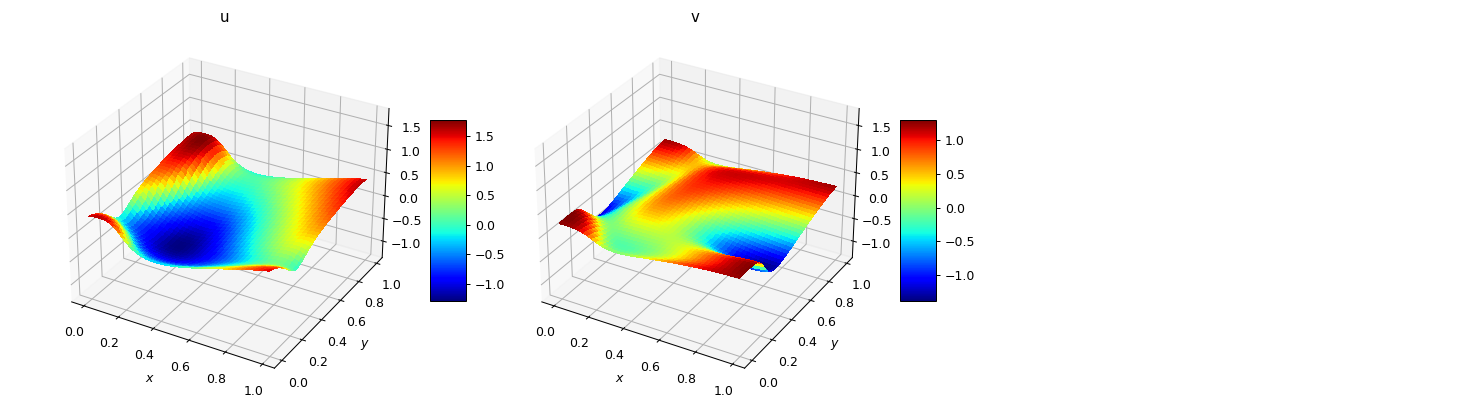

In [28]:
# %matplotlib notebook
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5), subplot_kw={"projection": "3d"})

plt.ion()

ax3.axis('off')

fig.show()
fig.canvas.draw()


x = torch.linspace(0, 1, Nx + 1)[:-1]
y = torch.linspace(0, 1, Nx + 1)[:-1]
X, Y = torch.meshgrid(x, y, indexing='ij')
# u = U[key].cpu().numpy()
# u0
# surf1 = ax1.plot_surface(X, Y, true[..., 0], cmap='jet', label='true', alpha=1.0, rstride=1, cstride=1, linewidth=0.0, antialiased=False)
surf1 = ax1.plot_surface(X, Y, u[key, 0].numpy(), cmap='jet', label='u', linewidth=0.0, antialiased=False)

# plt.colorbar()
# surf2 = ax2.plot_surface(X, Y, pred[..., 0], cmap='jet', label='pred', alpha=1.0, rstride=1, cstride=1, linewidth=0.0, antialiased=False)
surf2 = ax2.plot_surface(X, Y, v[key, 0].numpy(), cmap='jet', label='v',linewidth=0.0, antialiased=False)

# pcm = ax.pcolormesh(X, Y, u[0], vmin=-0.5, vmax=0.5, cmap='jet', shading='gouraud')
# divider = make_axes_locatable(ax2)
# cax = divider.append_axes("right", size="5%", pad=0.05)


# fig.colorbar(surf, shrink=0.5, aspect=5)

# ax.
# ax.set_zlim(-1, 1)
# display(ax.get_zlim())
zlim = ax1.get_zlim()
ax1.set_zlim(zlim)
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')
ax2.set_zlim(zlim)
ax2.set_xlabel('$x$')
ax2.set_ylabel('$y$')
ax1.set_title(f'u')
ax2.set_title(f'v')
# plt.axis('square')

plt.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)
plt.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)
plt.tight_layout()

# ax2.tight_layout()

# movie_dir = "Burgers2D_movie"
# movie_filename = "Burgers2D_movie"
# movie_files = []
# os.makedirs(movie_dir, exist_ok=True)
for i in range(len(u[key])):
    ax1.clear()
    ax2.clear()
#     pcm = ax.pcolormesh(X, Y, u[i], vmin=-0.5, vmax=0.5, cmap='jet', shading='gouraud')
#     surf1 = ax1.plot_surface(X, Y, true[..., i], cmap='jet', label='true', alpha=1.0, rstride=1, cstride=1, linewidth=0.0, antialiased=False)
    surf1 = ax1.plot_surface(X, Y, u[key, i].numpy(), cmap='jet', label='true', linewidth=0.0, antialiased=False)
#     surf2 = ax2.plot_surface(X, Y, pred[..., i], cmap='jet', label='pred', alpha=1.0, rstride=1, cstride=1, linewidth=0.0, antialiased=False)
    surf2 = ax2.plot_surface(X, Y, v[key, i].numpy(), cmap='jet', label='pred',linewidth=0.0, antialiased=False)

    ax1.set_zlim(zlim)
    ax1.set_xlabel('$x$')
    ax1.set_ylabel('$y$')
    ax2.set_zlim(zlim)
    ax2.set_xlabel('$x$')
    
    ax2.set_ylabel('$y$')
    ax1.set_title(f'u')
    ax2.set_title(f'v')
#     plt.title(f'Burgers Equation')
#     plt.axis('square')
    plt.tight_layout()
    fig.canvas.draw()
#     movie_path = os.path.join(movie_dir,f'{movie_filename}-{i:03}.png')
#     movie_files.append(movie_path)
#     plt.savefig(movie_path)



# Load Configuration File

In [13]:
config_file = 'configs/custom/burgers2D_coupled-0002.yaml'
config = load_config(config_file)
config['train']['ckpt'] = 'checkpoints/Burgers2D_coupled/Burgers2D_coupled-0002_50.pt'
display(config)

{'data': {'name': 'Burgers2D_coupled-0002',
  'total_num': 500,
  'n_train': 475,
  'n_test': 25,
  'nx': 128,
  'nt': 100,
  'sub': 1,
  'sub_t': 1,
  'nu': 0.01},
 'model': {'layers': [64, 64, 64, 64, 64],
  'modes1': [8, 8, 8, 8],
  'modes2': [8, 8, 8, 8],
  'modes3': [8, 8, 8, 8],
  'fc_dim': 128,
  'in_dim': 5,
  'out_dim': 2,
  'activation': 'gelu'},
 'train': {'batchsize': 1,
  'epochs': 150,
  'milestones': [25, 50, 75, 100, 125, 150],
  'base_lr': 0.001,
  'scheduler_gamma': 0.5,
  'ic_loss': 5.0,
  'f_loss': 2.0,
  'xy_loss': 5.0,
  'save_dir': 'Burgers2D_coupled',
  'save_name': 'Burgers2D_coupled-0002.pt',
  'ckpt': 'checkpoints/Burgers2D_coupled/Burgers2D_coupled-0002_50.pt',
  'ckpt_freq': 25},
 'log': {'project': 'PINO-Burgers', 'group': 'Burgers2D_coupled-0002'},
 'test': {'batchsize': 1,
  'ckpt': 'checkpoints/Burgers2D_coupled/Burgers2D_coupled-0002.pt'}}

# Define the DataLoaders

In [28]:
data = torch.stack([u,v], dim=-1)
dataset = DataLoader2D_coupled(data, config['data']['nx'], config['data']['nt'], config['data']['sub'], config['data']['sub_t'])
train_loader = dataset.make_loader(config['data']['n_train'], config['train']['batchsize'], start=0, train=True)
test_loader = dataset.make_loader(config['data']['n_test'], config['test']['batchsize'], start=config['data']['n_train'], train=False)

# Define the Model

In [29]:
log = False
# config = config_train
model = FNN3d(modes1=config['model']['modes1'],
              modes2=config['model']['modes2'],
              modes3=config['model']['modes3'],
              fc_dim=config['model']['fc_dim'],
              layers=config['model']['layers'], 
              in_dim=config['model']['in_dim'],
              out_dim=config['model']['out_dim'],
              activation=config['model']['activation'],
             ).to(device)

optimizer = Adam(model.parameters(), betas=(0.9, 0.999), lr=config['train']['base_lr'])
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                 milestones=config['train']['milestones'],
                                                 gamma=config['train']['scheduler_gamma'])

# Load from checkpoint

In [33]:
load_checkpoint(model, ckpt_path=config['train']['ckpt'], optimizer=None)
# load_checkpoint(model, ckpt_path=config['train']['ckpt'], optimizer=optimizer)

Weights loaded from checkpoints/Burgers2D_coupled/Burgers2D_coupled-0002_50.pt


# Train the Model

In [31]:
train_burgers2d_vec_pad(model,
                        dataset,
                        train_loader,
                        optimizer, 
                        scheduler,
                        config,
                        nu=config['data']['nu'],
                        padding=5,
                        rank=0,
                        log=log,
                        project=config['log']['project'],   
                        group=config['log']['group'])

  0%|          | 0/150 [00:00<?, ?it/s]/jet/home/shawngr2/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:173: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ../aten/src/ATen/native/Copy.cpp:237.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
Epoch 0, train loss: 0.52601 train f error: 0.00019; data l2 error: 0.06457; train ic error: 0.04055:   1%|          | 1/150 [03:35<8:56:19, 215.97s/it]

Checkpoint is saved at checkpoints/Burgers2D_coupled/Burgers2D_coupled-0002_0.pt


Epoch 25, train loss: 0.12816 train f error: 0.00002; data l2 error: 0.01495; train ic error: 0.01068:  17%|█▋        | 26/150 [1:33:10<7:24:23, 215.03s/it]

Checkpoint is saved at checkpoints/Burgers2D_coupled/Burgers2D_coupled-0002_25.pt


Epoch 50, train loss: 0.06393 train f error: 0.00001; data l2 error: 0.00754; train ic error: 0.00524:  34%|███▍      | 51/150 [3:02:39<5:54:29, 214.84s/it]

Checkpoint is saved at checkpoints/Burgers2D_coupled/Burgers2D_coupled-0002_50.pt


Epoch 51, train loss: 0.05701 train f error: 0.00001; data l2 error: 0.00676; train ic error: 0.00464:  35%|███▍      | 52/150 [3:06:27<5:51:24, 215.14s/it]


KeyboardInterrupt: 

# Evaluate Model

In [33]:
eval_burgers2D_vec(model,
                   test_loader,
                   config,
                   device,
                   nu=config['data']['nu'],
                   use_tqdm=True)

100%|██████████| 25/25 [00:04<00:00,  5.95it/s]

==Averaged relative L2 error mean: 0.3530698609352112, std error: 0.003914248982258837==
==Averaged equation error mean: 2.7594609451293945, std error: 0.05504732579113543==


In [34]:
eval_burgers2D_vec_pad(model,
                       test_loader,
                       config,
                       device,
                       nu=config['data']['nu'],
                       padding=5,
                       use_tqdm=True)

100%|██████████| 25/25 [00:03<00:00,  7.38it/s]


==Averaged relative L2 error mean: 0.008492460437119008, std error: 0.00024134049730094764==
==Averaged equation error mean: 8.129825873766095e-06, std error: 2.9532860027442813e-07==


# Generate Test Predictions

In [165]:
Nx = config['data']['nx']
Ny = config['data']['nx']
Nt = config['data']['nt'] + 1
Ntest = config['data']['n_test']
in_dim = config['model']['in_dim']
out_dim = config['model']['out_dim']
model.eval()
# model.to('cpu')
test_x = np.zeros((Ntest,Nx,Ny,Nt,in_dim))
preds_y = np.zeros((Ntest,Nx,Ny,Nt,out_dim))
test_y0 = np.zeros((Ntest,Nx,Ny,out_dim))
test_y = np.zeros((Ntest,Nx,Ny,Nt,out_dim))
with torch.no_grad():
    for i, data in enumerate(test_loader):
        data_x, data_y = data
        data_x, data_y = data_x.to(device), data_y.to(device)
        pred_y = model(data_x).reshape(data_y.shape)
        test_x[i] = data_x.cpu().numpy()
        test_y[i] = data_y.cpu().numpy()
        test_y0[i] = data_x[..., 0, :-out_dim].cpu().numpy() # same way as in training code
        preds_y[i] = pred_y.cpu().numpy()
#     data_loss = myloss(out, y)

## Padding

In [35]:
padding = 5
batch_size = config['test']['batchsize']
Nx = config['data']['nx']
Ny = config['data']['nx']
Nt = config['data']['nt'] + 1
Ntest = config['data']['n_test']
Ntrain = config['data']['n_train']
# Ntest = Ntrain
in_dim = config['model']['in_dim']
out_dim = config['model']['out_dim']

model.eval()
# model.to('cpu')
test_x = np.zeros((Ntest,Nx,Ny,Nt,in_dim))
preds_y = np.zeros((Ntest,Nx,Ny,Nt,out_dim))
test_y0 = np.zeros((Ntest,Nx,Ny,out_dim))
test_y = np.zeros((Ntest,Nx,Ny,Nt,out_dim))

with torch.no_grad():
    for i, data in enumerate(test_loader):
#     for i, data in enumerate(train_loader):
        data_x, data_y = data
        data_x, data_y = data_x.to(device), data_y.to(device)
#         data_x_pad = F.pad()
#         display(data_x.shape)
        data_x_pad = F.pad(data_x, (0, 0, 0, padding), "constant", 0)
        pred_y_pad = model(data_x_pad).reshape(batch_size, Nx, Ny, Nt + padding, out_dim)
        pred_y = pred_y_pad[..., :-padding, :].reshape(data_y.shape)
#         pred_y = model(data_x).reshape(data_y.shape)
        test_x[i] = data_x.cpu().numpy()
        test_y[i] = data_y.cpu().numpy()
        test_y0[i] = data_x[..., 0, -out_dim:].cpu().numpy() # same way as in training code
        preds_y[i] = pred_y.cpu().numpy()
#     data_loss = myloss(out, y)

# Plot Results

In [36]:
class BurgersDerivatives(object):
    def __init__(self, data, D=1.0, nu=0.01, device=None):
        if len(data.shape) == 4:
            data = data[None, :]
        batchsize = data.size(0)
        self.nx = nx = data.size(1)
        self.ny = ny = data.size(2)
        self.nt = nt = data.size(3)
        self.u = u = data[...,0].reshape(batchsize, nx, ny, nt)
        self.v = v = data[...,1].reshape(batchsize, nx, ny, nt)
        self.dt = dt = D / (nt-1)
        self.dx = dx = D / (nx)
        self.nu = nu
    #     u2 = u**2
        self.u_h = u_h = torch.fft.fftn(u, dim=[1, 2])
        self.v_h = v_h = torch.fft.fftn(v, dim=[1, 2])
    #     u2_h = torch.fft.fftn(u2, dim=[1, 2])
        # Wavenumbers in y-direction
        self.k_max = k_max = nx//2
        N = nx
        self.k_x = k_x = torch.cat((torch.arange(start=0, end=k_max, step=1, device=device),
                         torch.arange(start=-k_max, end=0, step=1, device=device)), 0).reshape(N, 1).repeat(1, N).reshape(1,N,N,1)
        self.k_y = k_y = torch.cat((torch.arange(start=0, end=k_max, step=1, device=device),
                         torch.arange(start=-k_max, end=0, step=1, device=device)), 0).reshape(1, N).repeat(N, 1).reshape(1,N,N,1)
        
        
        self.ut, self.ux, self.uy, self.uxx, self.uyy = self.calc_derivs(u)
        self.vt, self.vx, self.vy, self.vxx, self.vyy = self.calc_derivs(v)
        self.Du, self.Dv = self.calc_res()
        
    def calc_derivs(self, u):
        u_h = torch.fft.fftn(u, dim=[1, 2])
        ux_h = 2j *np.pi*self.k_x*u_h
        uxx_h = 2j *np.pi*self.k_x*ux_h
        uy_h = 2j *np.pi*self.k_y*u_h
        uyy_h = 2j *np.pi*self.k_y*uy_h
        ux = torch.fft.irfftn(ux_h[:, :, :self.k_max+1], dim=[1, 2])
        uy = torch.fft.irfftn(uy_h[:, :, :self.k_max+1], dim=[1, 2])
        uxx = torch.fft.irfftn(uxx_h[:, :, :self.k_max+1], dim=[1, 2])
        uyy = torch.fft.irfftn(uyy_h[:, :, :self.k_max+1], dim=[1, 2])
        ut = (u[..., 2:] - u[..., :-2]) / (2 * self.dt)
        return ut, ux, uy, uxx, uyy
        
    def calc_res(self):
        Du = self.ut + (self.u*self.ux + self.v*self.uy - self.nu*(self.uxx + self.uyy))[..., 1:-1]
        Dv = self.vt + (self.u*self.vx + self.v*self.vy - self.nu*(self.vxx + self.vyy))[..., 1:-1]
        return Du, Dv
    
    def get_u_derivs(self, key=None, key_t=None):
        if key is None:
            key = slice(None)
        if key_t is None:
            key_t = slice(None)
        ut = self.ut[key, ..., key_t].cpu().numpy()
        ux = self.ux[key, ..., key_t].cpu().numpy()
        uy = self.uy[key, ..., key_t].cpu().numpy()
        uxx = self.uxx[key, ..., key_t].cpu().numpy()
        uyy = self.uyy[key, ..., key_t].cpu().numpy()
        return ut, ux, uy, uxx, uyy
    
    def get_v_derivs(self, key=None, key_t=None):
        if key is None:
            key = slice(None)
        if key_t is None:
            key_t = slice(None)
        vt = self.vt[key, ..., key_t].cpu().numpy()
        vx = self.vx[key, ..., key_t].cpu().numpy()
        vy = self.vy[key, ..., key_t].cpu().numpy()
        vxx = self.vxx[key, ..., key_t].cpu().numpy()
        vyy = self.vyy[key, ..., key_t].cpu().numpy()
        return vt, vx, vy, vxx, vyy
    
    def get_res(self, key=None, key_t=None):
        if key is None:
            key = slice(None)
        if key_t is None:
            key_t = slice(None)
        Du = self.Du[key, ..., key_t].cpu().numpy()
        Dv = self.Dv[key, ..., key_t].cpu().numpy()
        return Du, Dv

In [37]:
PINO_loss_burgers2D_vec(torch.tensor(preds_y, device=device), torch.tensor(test_y0, device=device), nu=0.01)

(tensor(0.0036, device='cuda:0', dtype=torch.float64),
 tensor(8.1299e-06, device='cuda:0', dtype=torch.float64))

In [36]:
PINO_loss_burgers2D_vec(torch.tensor(test_y, device=device), torch.tensor(test_y0, device=device), nu=0.01)

(tensor(0., device='cuda:0', dtype=torch.float64),
 tensor(0.0001, device='cuda:0', dtype=torch.float64))

In [37]:
derivs_pred = BurgersDerivatives(torch.tensor(preds_y))
derivs_true = BurgersDerivatives(torch.tensor(test_y))

In [38]:
u = torch.tensor(preds_y[...,0], device=device)
v = torch.tensor(preds_y[...,1], device=device)

In [39]:
Du, Dv = FDM_Burgers2D_Vec(u, v, nu=0.01)
display(Du.std())
display(Dv.std())

tensor(0.1781, device='cuda:0', dtype=torch.float64)

tensor(0.1757, device='cuda:0', dtype=torch.float64)

In [40]:
Ds = torch.stack([Du, Dv], dim=-1)
f = torch.zeros(Ds.shape, device=Ds.device)
loss_f = F.mse_loss(Ds, f)

In [41]:
loss_f

tensor(0.0313, device='cuda:0', dtype=torch.float64)

In [42]:
Ds.std()

tensor(0.1770, device='cuda:0', dtype=torch.float64)

In [38]:
key = 0
# key_t = (Nt - 3)
key_t = ((Nt - 1) // 2)*2
pred = preds_y[key]
true = test_y[key]


a = test_x[key]
# Nt, Nx, _ = a.shape
u0 = a[..., 0, -2]
v0 = a[..., 0, -1]
pred_u = pred[..., key_t, 0]
pred_v = pred[..., key_t, 1]
true_u = true[..., key_t, 0]
true_v = true[..., key_t, 1]

# T = a[:,:,2]
# X = a[:,:,1]
# x = X[0]
x = torch.linspace(0, 1, Nx + 1)[:-1]
y = torch.linspace(0, 1, Nx + 1)[:-1]
X, Y = torch.meshgrid(x, y, indexing='ij')
t = a[0, 0, key_t, 2]
grid_x, grid_y, grid_t = get_grid3d(Nx, Nt)
# X = X.reshape(Nx, Nx)

In [39]:
pred_ut, pred_ux, pred_uy, pred_uxx, pred_uyy = derivs_pred.get_u_derivs(key, key_t)
pred_vt, pred_vx, pred_vy, pred_vxx, pred_vyy = derivs_pred.get_v_derivs(key, key_t)
pred_Du, pred_Dv = derivs_pred.get_res(key, key_t)

true_ut, true_ux, true_uy, true_uxx, true_uyy = derivs_true.get_u_derivs(key, key_t)
true_vt, true_vx, true_vy, true_vxx, true_vyy = derivs_true.get_v_derivs(key, key_t)
true_Du, true_Dv = derivs_true.get_res(key, key_t)

NameError: name 'derivs_pred' is not defined

<IPython.core.display.Javascript object>


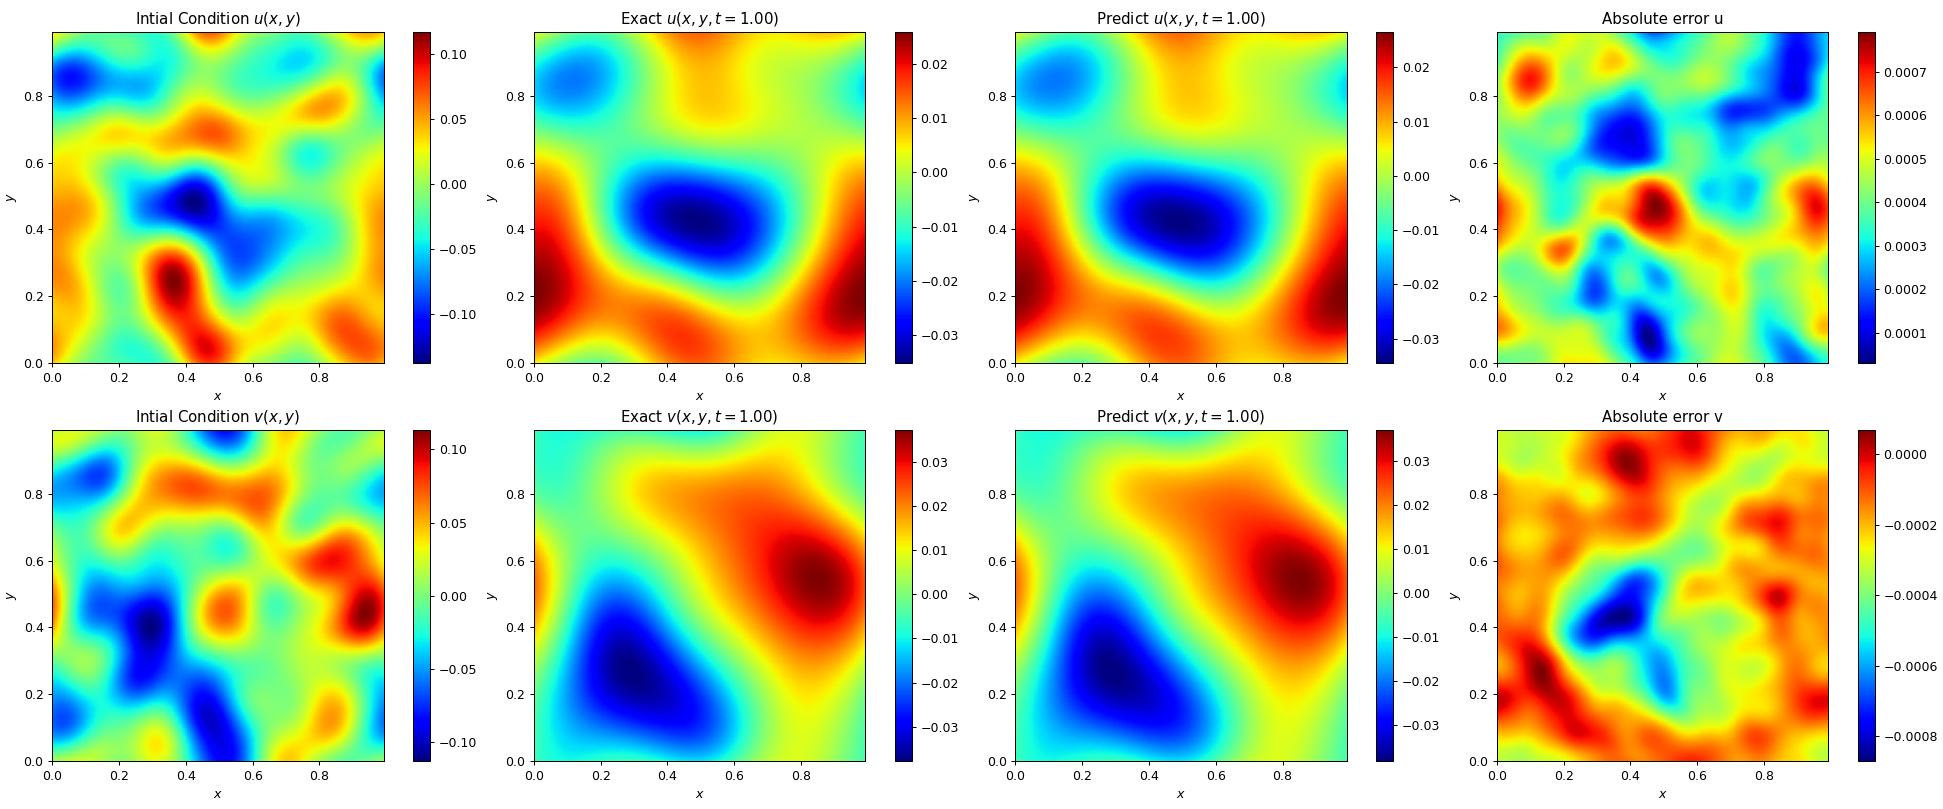

(0.0, 0.9921875, 0.0, 0.9921875)

In [40]:
fig = plt.figure(figsize=(24,10))
plt.subplot(2,4,1)

plt.pcolormesh(X, Y, u0, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Intial Condition $u(x,y)$')
plt.tight_layout()
plt.axis('square')

plt.subplot(2,4,2)
# plt.pcolor(XX,TT, S_test, cmap='jet')
plt.pcolormesh(X, Y, true_u, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(f'Exact $u(x,y,t={t:.2f})$')
plt.tight_layout()
plt.axis('square')

plt.subplot(2,4,3)
# plt.pcolor(XX,TT, S_pred, cmap='jet')
plt.pcolormesh(X, Y, pred_u, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(f'Predict $u(x,y,t={t:.2f})$')
plt.axis('square')

plt.tight_layout()

plt.subplot(2,4,4)
# plt.pcolor(XX,TT, S_pred - S_test, cmap='jet')
plt.pcolormesh(X, Y, pred_u - true_u, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Absolute error u')
plt.tight_layout()
plt.axis('square')

plt.subplot(2,4,5)
plt.pcolormesh(X, Y, v0, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Intial Condition $v(x,y)$')
plt.tight_layout()
plt.axis('square')

plt.subplot(2,4,6)
# plt.pcolor(XX,TT, S_test, cmap='jet')
plt.pcolormesh(X, Y, true_v, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(f'Exact $v(x,y,t={t:.2f})$')
plt.tight_layout()
plt.axis('square')

plt.subplot(2,4,7)
# plt.pcolor(XX,TT, S_pred, cmap='jet')
plt.pcolormesh(X, Y, pred_v, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(f'Predict $v(x,y,t={t:.2f})$')
plt.axis('square')

plt.tight_layout()

plt.subplot(2,4,8)
# plt.pcolor(XX,TT, S_pred - S_test, cmap='jet')
plt.pcolormesh(X, Y, pred_v - true_v, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Absolute error v')
plt.tight_layout()
plt.axis('square')


# plt.show()

<IPython.core.display.Javascript object>


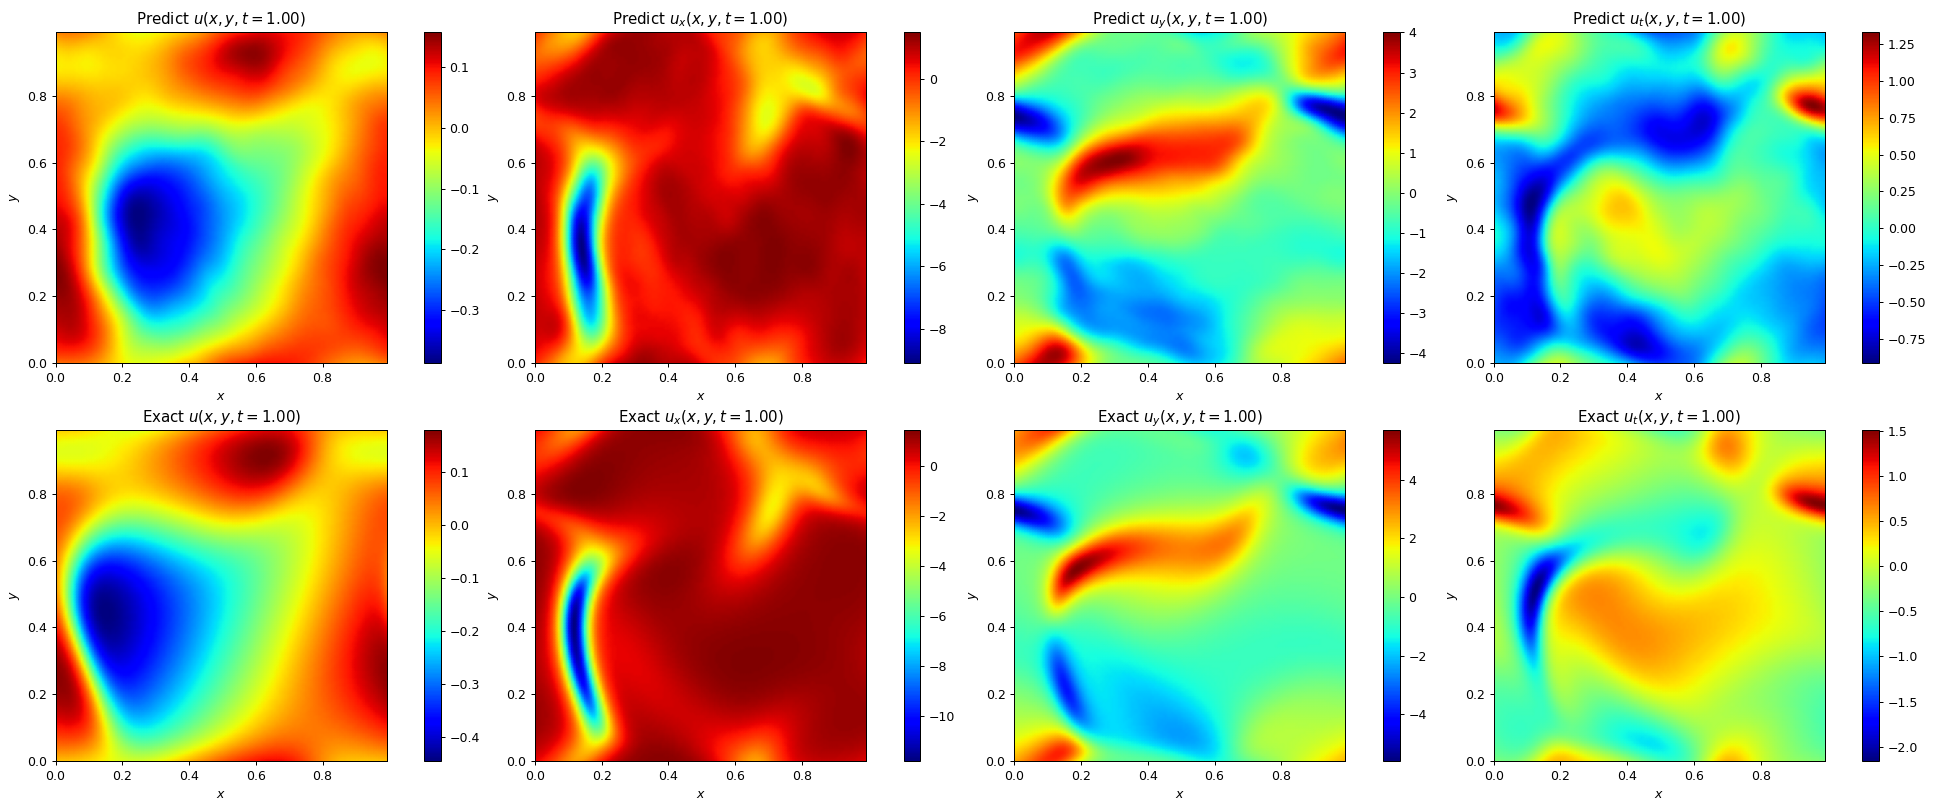

(0.0, 0.9921875, 0.0, 0.9921875)

In [52]:
fig = plt.figure(figsize=(24,10))
plt.subplot(2,4,1)

plt.pcolormesh(X, Y, pred_u, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(f'Predict $u(x,y,t={t:.2f})$')
plt.tight_layout()
plt.axis('square')

plt.subplot(2,4,2)
plt.pcolormesh(X, Y, pred_ux, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(f'Predict $u_x(x,y,t={t:.2f})$')
plt.tight_layout()
plt.axis('square')

plt.subplot(2,4,3)
plt.pcolormesh(X, Y, pred_uy, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(f'Predict $u_y(x,y,t={t:.2f})$')
plt.axis('square')

plt.tight_layout()

plt.subplot(2,4,4)
plt.pcolormesh(X, Y, pred_ut, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(f'Predict $u_t(x,y,t={t:.2f})$')
plt.tight_layout()
plt.axis('square')

plt.subplot(2,4,5)
plt.pcolormesh(X, Y, true_u, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(f'Exact $u(x,y,t={t:.2f})$')
plt.tight_layout()
plt.axis('square')

plt.subplot(2,4,6)
plt.pcolormesh(X, Y, true_ux, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(f'Exact $u_x(x,y,t={t:.2f})$')
plt.tight_layout()
plt.axis('square')

plt.subplot(2,4,7)
plt.pcolormesh(X, Y, true_uy, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(f'Exact $u_y(x,y,t={t:.2f})$')
plt.axis('square')

plt.tight_layout()

plt.subplot(2,4,8)
plt.pcolormesh(X, Y, true_ut, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(f'Exact $u_t(x,y,t={t:.2f})$')
plt.tight_layout()
plt.axis('square')


# plt.show()

<IPython.core.display.Javascript object>


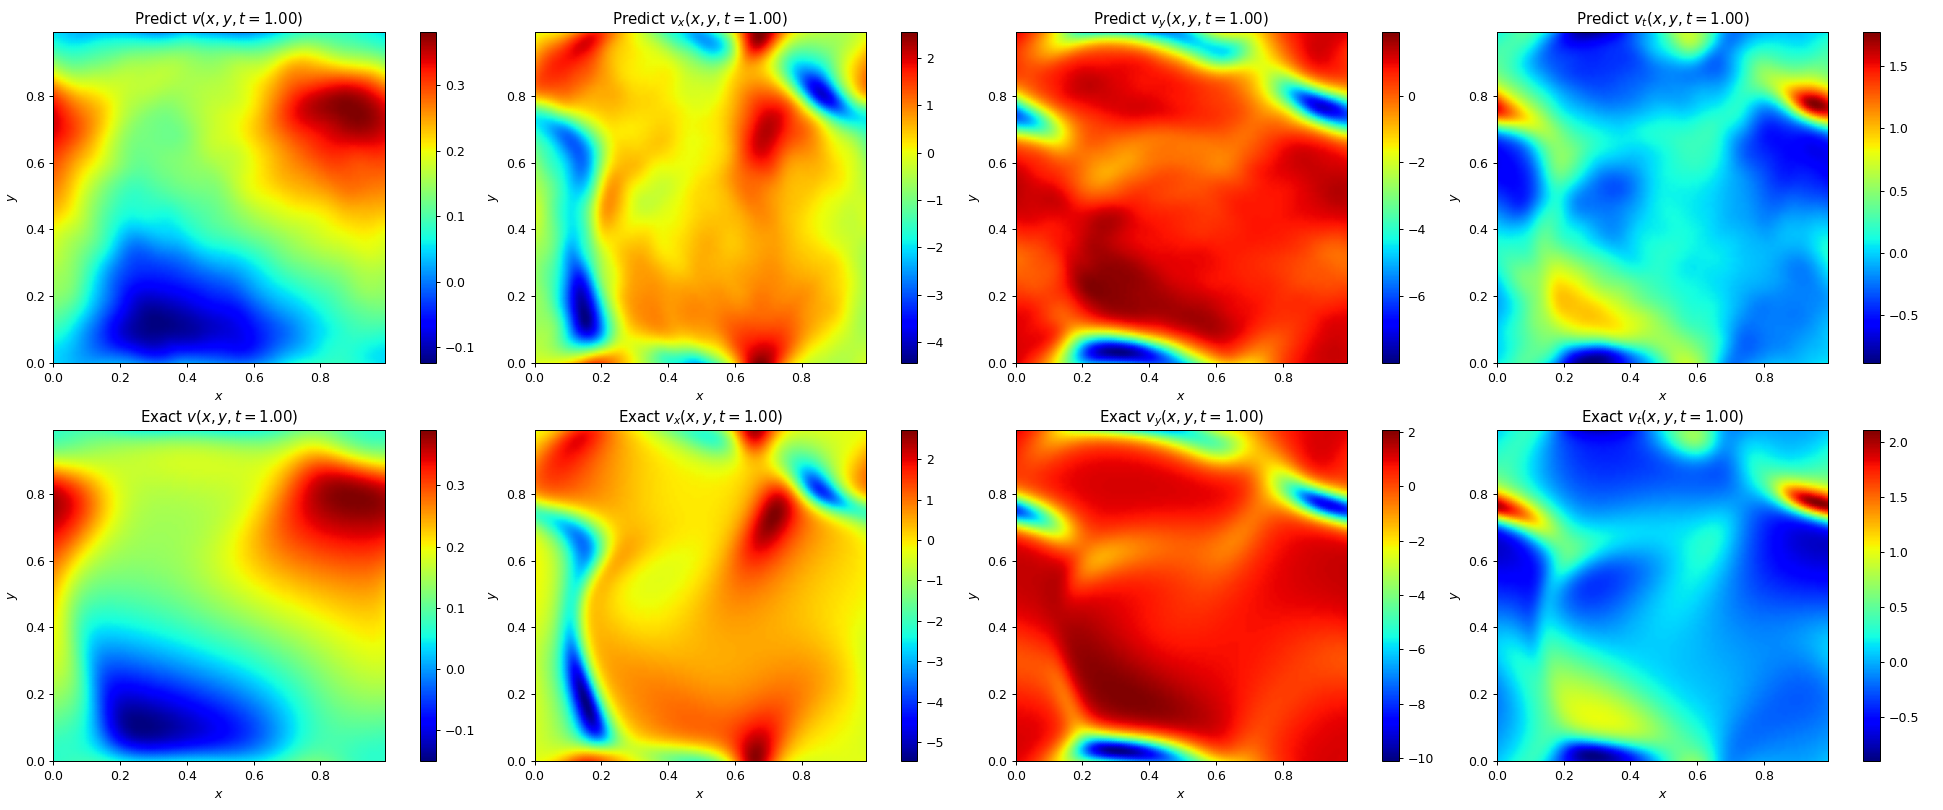

(0.0, 0.9921875, 0.0, 0.9921875)

In [53]:
fig = plt.figure(figsize=(24,10))
plt.subplot(2,4,1)

plt.pcolormesh(X, Y, pred_v, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(f'Predict $v(x,y,t={t:.2f})$')
plt.tight_layout()
plt.axis('square')

plt.subplot(2,4,2)
plt.pcolormesh(X, Y, pred_vx, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(f'Predict $v_x(x,y,t={t:.2f})$')
plt.tight_layout()
plt.axis('square')

plt.subplot(2,4,3)
plt.pcolormesh(X, Y, pred_vy, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(f'Predict $v_y(x,y,t={t:.2f})$')
plt.axis('square')

plt.tight_layout()

plt.subplot(2,4,4)
plt.pcolormesh(X, Y, pred_vt, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(f'Predict $v_t(x,y,t={t:.2f})$')
plt.tight_layout()
plt.axis('square')

plt.subplot(2,4,5)
plt.pcolormesh(X, Y, true_v, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(f'Exact $v(x,y,t={t:.2f})$')
plt.tight_layout()
plt.axis('square')

plt.subplot(2,4,6)
plt.pcolormesh(X, Y, true_vx, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(f'Exact $v_x(x,y,t={t:.2f})$')
plt.tight_layout()
plt.axis('square')

plt.subplot(2,4,7)
plt.pcolormesh(X, Y, true_vy, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(f'Exact $v_y(x,y,t={t:.2f})$')
plt.axis('square')

plt.tight_layout()

plt.subplot(2,4,8)
plt.pcolormesh(X, Y, true_vt, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(f'Exact $v_t(x,y,t={t:.2f})$')
plt.tight_layout()
plt.axis('square')


# plt.show()

<IPython.core.display.Javascript object>


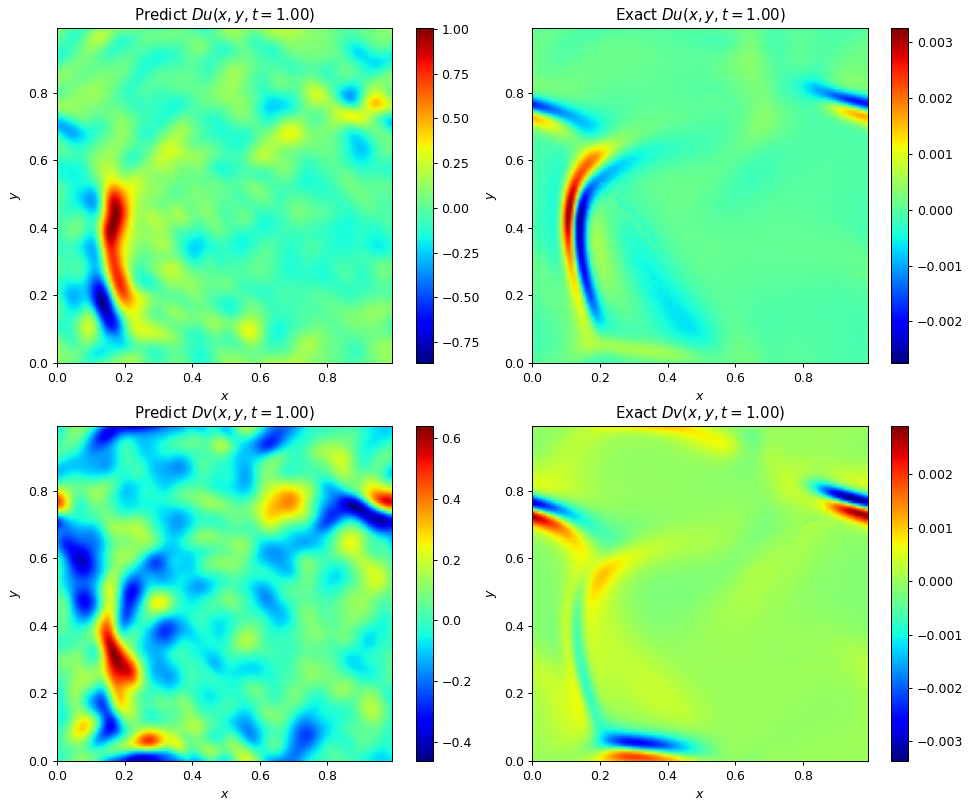

(0.0, 0.9921875, 0.0, 0.9921875)

In [54]:
fig = plt.figure(figsize=(12,10))
plt.subplot(2,2,1)

plt.pcolormesh(X, Y, pred_Du, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(f'Predict $Du(x,y,t={t:.2f})$')
plt.tight_layout()
plt.axis('square')

plt.subplot(2,2,2)
plt.pcolormesh(X, Y, true_Du, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(f'Exact $Du(x,y,t={t:.2f})$')
plt.tight_layout()
plt.axis('square')

plt.subplot(2,2,3)
plt.pcolormesh(X, Y, pred_Dv, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(f'Predict $Dv(x,y,t={t:.2f})$')
plt.axis('square')
plt.tight_layout()

plt.subplot(2,2,4)
plt.pcolormesh(X, Y, true_Dv, cmap='jet', shading='gouraud')
plt.colorbar()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(f'Exact $Dv(x,y,t={t:.2f})$')
plt.tight_layout()
plt.axis('square')


In [55]:
axs

NameError: name 'axs' is not defined

In [56]:
true_u.shape

(128, 128)

In [57]:
true_u.shape

(128, 128)

<IPython.core.display.Javascript object>


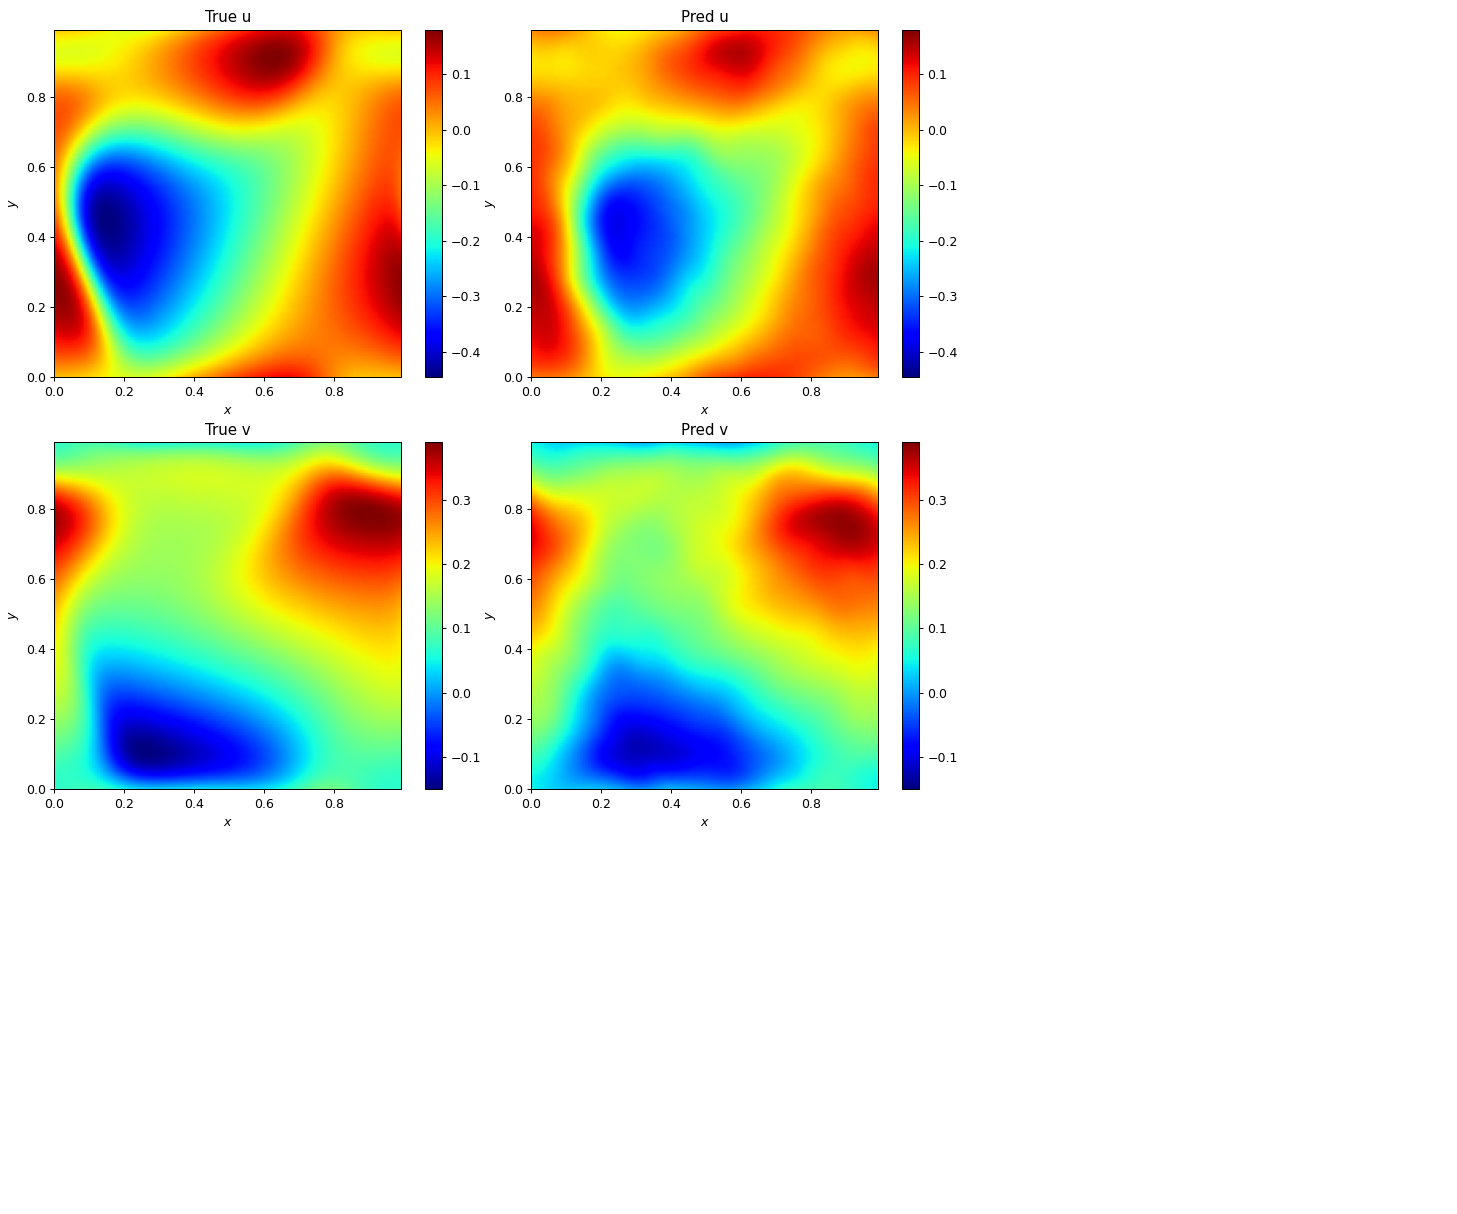

In [58]:
# %matplotlib notebook
fig, axs = plt.subplots(3, 3, figsize=(18,15))

ax1 = axs[0,0]
ax2 = axs[0,1]
ax3 = axs[1,0]
ax4 = axs[1,1]

plt.ion()

axs[0,2].axis('off')
axs[1,2].axis('off')
axs[2,0].axis('off')
axs[2,1].axis('off')
axs[2,2].axis('off')

fig.show()
fig.canvas.draw()


x = torch.linspace(0, 1, Nx + 1)[:-1]
y = torch.linspace(0, 1, Nx + 1)[:-1]
X, Y = torch.meshgrid(x, y, indexing='ij')
# u = U[key].cpu().numpy()
# u0
pcm1 = ax1.pcolormesh(X, Y, true[..., -1, 0], cmap='jet', label='true u', shading='gouraud')
pcm2 = ax2.pcolormesh(X, Y, pred[..., -1, 0], cmap='jet', label='pred u', shading='gouraud')
pcm3 = ax3.pcolormesh(X, Y, true[..., -1, 1], cmap='jet', label='true v', shading='gouraud')
pcm4 = ax4.pcolormesh(X, Y, pred[..., -1, 1], cmap='jet', label='pred v', shading='gouraud')


# pcm = ax.pcolormesh(X, Y, u[0], vmin=-0.4, vmax=0.4, cmap='jet', shading='gouraud')
# divider = make_axes_locatable(ax2)
# cax = divider.append_axes("right", size="4%", pad=0.04)


# fig.colorbar(pcm, shrink=0.4, aspect=4)

# ax.
# ax.set_clim(-1, 1)
# display(ax.get_clim())
clim12 = pcm1.get_clim()
pcm1.set_clim(clim12)
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')
pcm2.set_clim(clim12)
ax2.set_xlabel('$x$')
ax2.set_ylabel('$y$')
ax1.set_title(f'True u')
ax2.set_title(f'Pred u')


clim34 = pcm3.get_clim()
pcm3.set_clim(clim34)
ax3.set_xlabel('$x$')
ax3.set_ylabel('$y$')
pcm4.set_clim(clim34)
ax4.set_xlabel('$x$')
ax4.set_ylabel('$y$')
ax3.set_title(f'True v')
ax4.set_title(f'Pred v')


# plt.axis('square')

plt.colorbar(pcm1, ax=ax1)
plt.colorbar(pcm2, ax=ax2)
plt.colorbar(pcm3, ax=ax3)
plt.colorbar(pcm4, ax=ax4)

ax1.axis('square')
ax2.axis('square')
ax3.axis('square')
ax4.axis('square')
plt.tight_layout()
# ax2.tight_layout()

# movie_dir = "Burgers2D_movie"
# movie_filename = "Burgers2D_movie"
# movie_files = []
# os.makedirs(movie_dir, exist_ok=True)
for i in range(true.shape[-2]):
    ax1.clear()
    ax2.clear()
    ax3.clear()
    ax4.clear()
    pcm1 = ax1.pcolormesh(X, Y, true[..., i, 0], cmap='jet', label='true u', shading='gouraud')
    pcm2 = ax2.pcolormesh(X, Y, pred[..., i, 0], cmap='jet', label='pred u', shading='gouraud')
    pcm3 = ax3.pcolormesh(X, Y, true[..., i, 1], cmap='jet', label='true v', shading='gouraud')
    pcm4 = ax4.pcolormesh(X, Y, pred[..., i, 1], cmap='jet', label='pred v', shading='gouraud')

    pcm1.set_clim(clim12)
    ax1.set_xlabel('$x$')
    ax1.set_ylabel('$y$')
    pcm2.set_clim(clim12)
    ax2.set_xlabel('$x$')
    ax2.set_ylabel('$y$')
    ax1.set_title(f'True u')
    ax2.set_title(f'Pred u')
    
    pcm3.set_clim(clim34)
    ax3.set_xlabel('$x$')
    ax3.set_ylabel('$y$')
    pcm4.set_clim(clim34)
    ax4.set_xlabel('$x$')
    ax4.set_ylabel('$y$')
    ax3.set_title(f'True v')
    ax4.set_title(f'Pred v')
#     plt.title(f'Burgers Equation')
    ax1.axis('square')
    ax2.axis('square')
    ax3.axis('square')
    ax4.axis('square')
    plt.tight_layout()
    fig.canvas.draw()
#     movie_path = os.path.join(movie_dir,f'{movie_filename}-{i:03}.png')
#     movie_files.append(movie_path)
#     plt.savefig(movie_path)



<IPython.core.display.Javascript object>


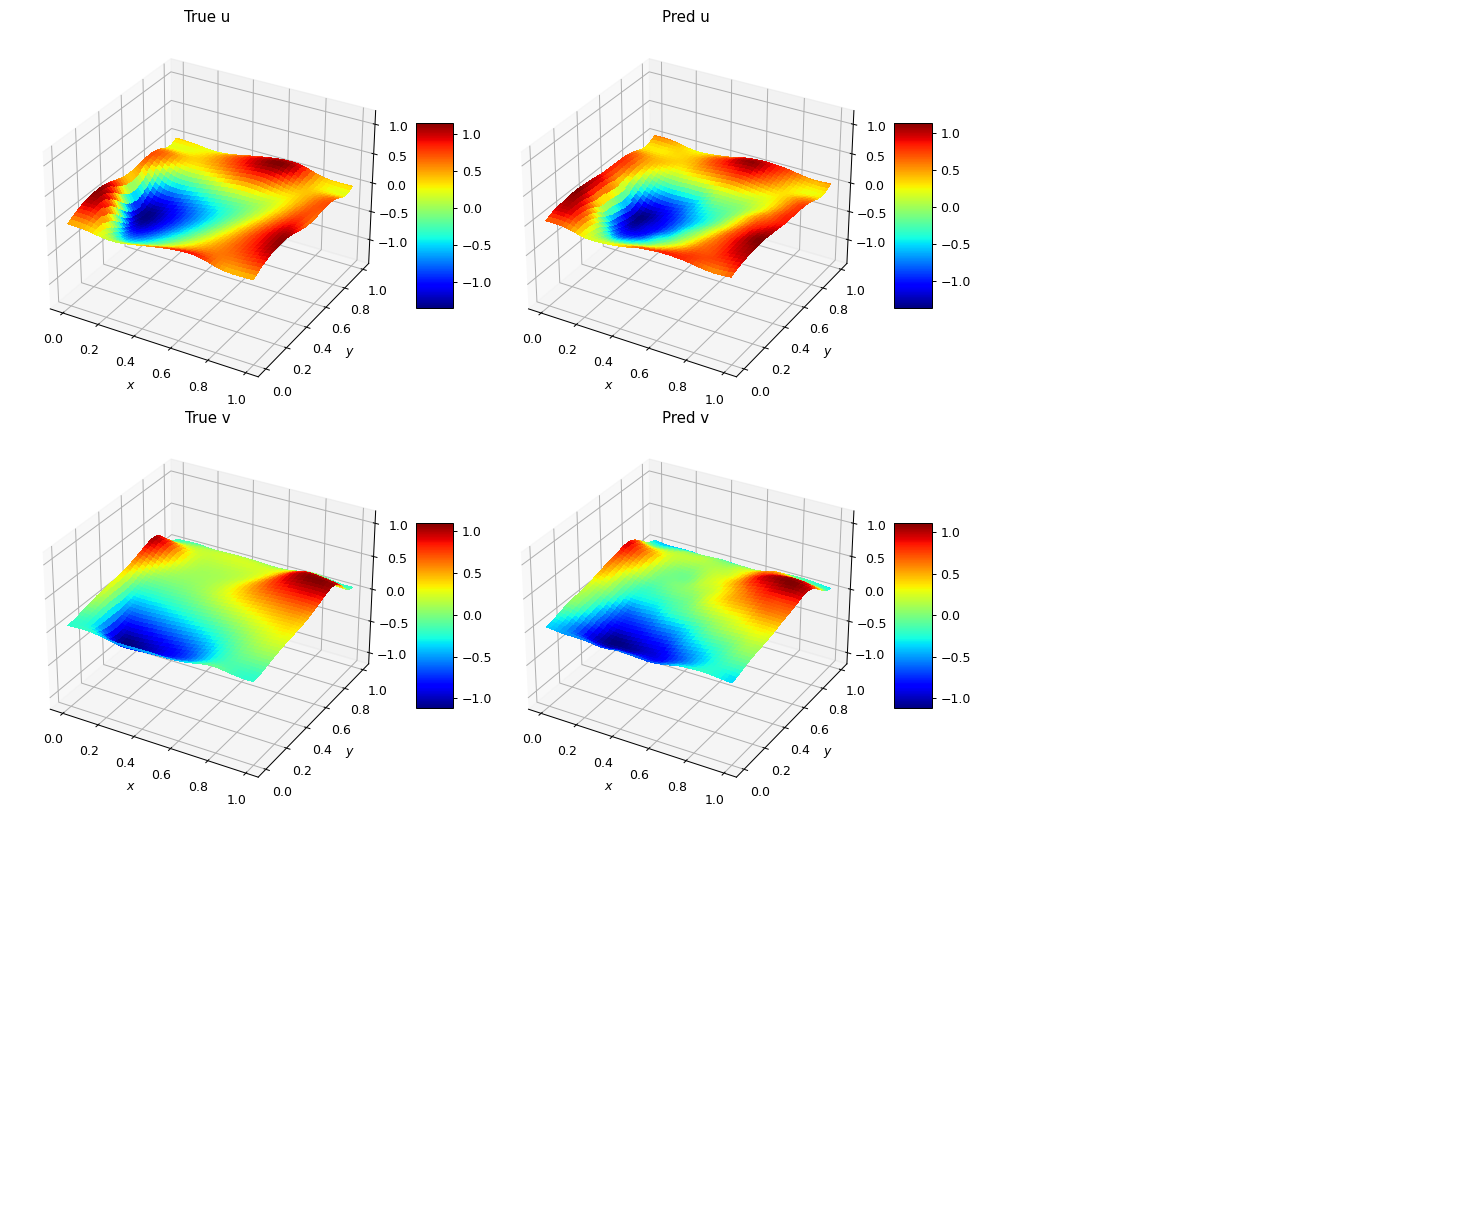

In [59]:
# %matplotlib notebook
fig, axs = plt.subplots(3, 3, figsize=(18,15), subplot_kw={"projection": "3d"})

ax1 = axs[0,0]
ax2 = axs[0,1]
ax3 = axs[1,0]
ax4 = axs[1,1]

plt.ion()

axs[0,2].axis('off')
axs[1,2].axis('off')
axs[2,0].axis('off')
axs[2,1].axis('off')
axs[2,2].axis('off')

fig.show()
fig.canvas.draw()


x = torch.linspace(0, 1, Nx + 1)[:-1]
y = torch.linspace(0, 1, Nx + 1)[:-1]
X, Y = torch.meshgrid(x, y, indexing='ij')
# u = U[key].cpu().numpy()
# u0

surf1 = ax1.plot_surface(X, Y, true[..., 0, 0], cmap='jet', label='true u', linewidth=0.0, antialiased=False)
surf2 = ax2.plot_surface(X, Y, pred[..., 0, 0], cmap='jet', label='pred u', linewidth=0.0, antialiased=False)
surf3 = ax3.plot_surface(X, Y, true[..., 0, 1], cmap='jet', label='true v', linewidth=0.0, antialiased=False)
surf4 = ax4.plot_surface(X, Y, pred[..., 0, 1], cmap='jet', label='pred v', linewidth=0.0, antialiased=False)


# surf = ax.pcolormesh(X, Y, u[0], vmin=-0.4, vmax=0.4, cmap='jet', shading='gouraud')
# divider = make_axes_locatable(ax2)
# cax = divider.append_axes("right", size="4%", pad=0.04)


# fig.colorbar(surf, shrink=0.4, aspect=4)

# ax.
# ax.set_zlim(-1, 1)
# display(ax.get_zlim())
zlim12 = ax1.get_zlim()
ax1.set_zlim(zlim12)
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')
ax2.set_zlim(zlim12)
ax2.set_xlabel('$x$')
ax2.set_ylabel('$y$')
ax1.set_title(f'True u')
ax2.set_title(f'Pred u')


zlim34 = ax3.get_zlim()
ax3.set_zlim(zlim34)
ax3.set_xlabel('$x$')
ax3.set_ylabel('$y$')
ax4.set_zlim(zlim34)
ax4.set_xlabel('$x$')
ax4.set_ylabel('$y$')
ax3.set_title(f'True v')
ax4.set_title(f'Pred v')


# plt.axis('square')

plt.colorbar(surf1, ax=ax1, shrink=0.5, aspect=5)
plt.colorbar(surf2, ax=ax2, shrink=0.5, aspect=5)
plt.colorbar(surf3, ax=ax3, shrink=0.5, aspect=5)
plt.colorbar(surf4, ax=ax4, shrink=0.5, aspect=5)

# ax1.axis('square')
# ax2.axis('square')
# ax3.axis('square')
# ax4.axis('square')
plt.tight_layout()
# ax2.tight_layout()

# movie_dir = "Burgers2D_movie"
# movie_filename = "Burgers2D_movie"
# movie_files = []
# os.makedirs(movie_dir, exist_ok=True)
for i in range(true.shape[-2]):
    ax1.clear()
    ax2.clear()
    ax3.clear()
    ax4.clear()
    surf1 = ax1.plot_surface(X, Y, true[..., i, 0], cmap='jet', label='true u', linewidth=0.0, antialiased=False)
    surf2 = ax2.plot_surface(X, Y, pred[..., i, 0], cmap='jet', label='pred u', linewidth=0.0, antialiased=False)
    surf3 = ax3.plot_surface(X, Y, true[..., i, 1], cmap='jet', label='true v', linewidth=0.0, antialiased=False)
    surf4 = ax4.plot_surface(X, Y, pred[..., i, 1], cmap='jet', label='pred v', linewidth=0.0, antialiased=False)

#     zlim12 = ax1.get_zlim()
    ax1.set_zlim(zlim12)
    ax1.set_xlabel('$x$')
    ax1.set_ylabel('$y$')
    ax2.set_zlim(zlim12)
    ax2.set_xlabel('$x$')
    ax2.set_ylabel('$y$')
    ax1.set_title(f'True u')
    ax2.set_title(f'Pred u')


#     zlim34 = ax3.get_zlim()
    ax3.set_zlim(zlim34)
    ax3.set_xlabel('$x$')
    ax3.set_ylabel('$y$')
    ax4.set_zlim(zlim34)
    ax4.set_xlabel('$x$')
    ax4.set_ylabel('$y$')
    ax3.set_title(f'True v')
    ax4.set_title(f'Pred v')

#     ax1.axis('square')
#     ax2.axis('square')
#     ax3.axis('square')
#     ax4.axis('square')
    plt.tight_layout()
    fig.canvas.draw()
#     movie_path = os.path.join(movie_dir,f'{movie_filename}-{i:03}.png')
#     movie_files.append(movie_path)
#     plt.savefig(movie_path)





<IPython.core.display.Javascript object>


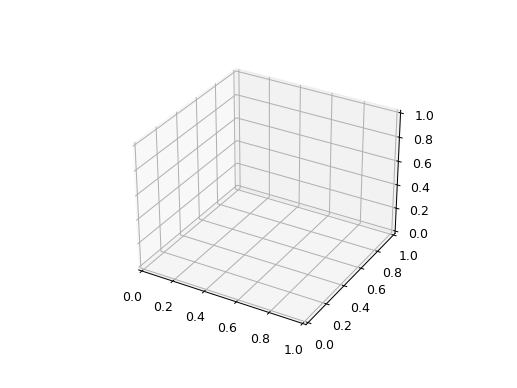

ValueError: Argument Z must be 2-dimensional.

In [60]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

plt.ion()

fig.show()
fig.canvas.draw()


x = torch.linspace(0, 1, Nx + 1)[:-1]
y = torch.linspace(0, 1, Nx + 1)[:-1]
X, Y = torch.meshgrid(x, y, indexing='ij')
surf = ax.plot_surface(X, Y, pred[..., -1] - true[..., -1], cmap='jet', linewidth=0, antialiased=False)
# pcm = ax.pcolormesh(X, Y, u[0], vmin=-0.5, vmax=0.5, cmap='jet', shading='gouraud')
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.05)

# plt.colorbar(surf, ax=ax)
fig.colorbar(surf, shrink=0.5, aspect=5)

# ax.
# ax.set_zlim(-1, 1)
# display(ax.get_zlim())
zlim = ax.get_zlim()
ax.set_zlim(zlim)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title(f'Burgers Equation Error')
# plt.axis('square')
plt.tight_layout()

# movie_dir = "Burgers2D_movie"
# movie_filename = "Burgers2D_movie"
# movie_files = []
# os.makedirs(movie_dir, exist_ok=True)
for i in range(len(u)):
    ax.clear()
#     pcm = ax.pcolormesh(X, Y, u[i], vmin=-0.5, vmax=0.5, cmap='jet', shading='gouraud')
    surf = ax.plot_surface(X, Y, pred[..., i] - true[..., i], cmap='jet', linewidth=0, antialiased=False)
    ax.set_zlim(zlim)
#     plt.colorbar(pcm, ax=ax)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
#     ax.set_zlabel('$u$')
    plt.title(f'Burgers Equation Error')
#     plt.axis('square')
    plt.tight_layout()
    fig.canvas.draw()
#     movie_path = os.path.join(movie_dir,f'{movie_filename}-{i:03}.png')
#     movie_files.append(movie_path)
#     plt.savefig(movie_path)



<IPython.core.display.Javascript object>


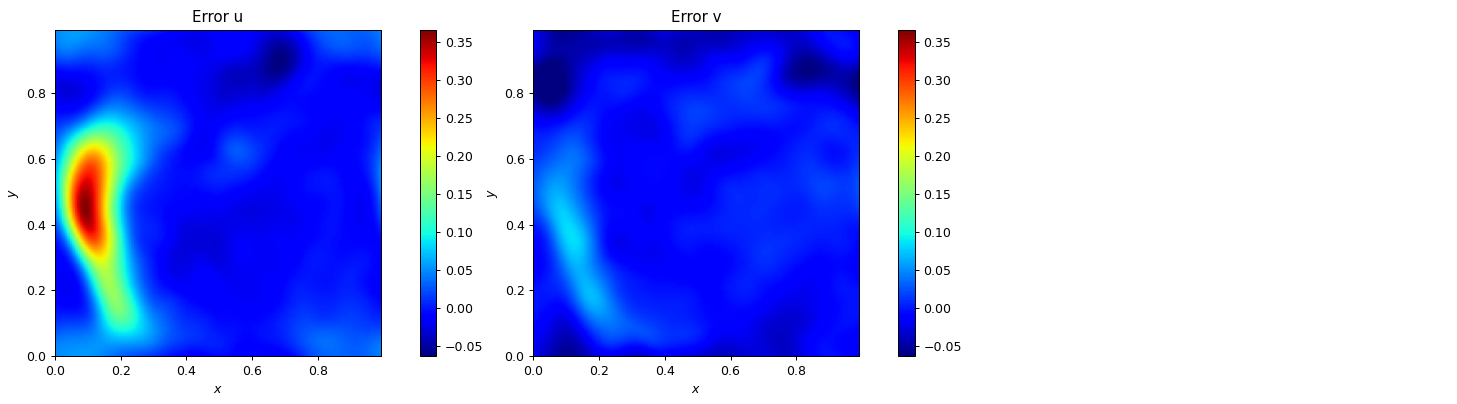

In [61]:
# %matplotlib notebook
fig, axs = plt.subplots(1, 3, figsize=(18,5))

ax1 = axs[0]
ax2 = axs[1]
# ax3 = axs[0]

plt.ion()

axs[2].axis('off')
# axs[1,2].axis('off')
# axs[2,0].axis('off')
# axs[2,1].axis('off')
# axs[2,2].axis('off')

fig.show()
fig.canvas.draw()


x = torch.linspace(0, 1, Nx + 1)[:-1]
y = torch.linspace(0, 1, Nx + 1)[:-1]
X, Y = torch.meshgrid(x, y, indexing='ij')
# u = U[key].cpu().numpy()
# u0
pcm1 = ax1.pcolormesh(X, Y, pred[..., -1, 0] - true[..., -1, 0], cmap='jet', label='error u', shading='gouraud')
pcm2 = ax2.pcolormesh(X, Y, pred[..., -1, 1] - true[..., -1, 1], cmap='jet', label='error v', shading='gouraud')


# pcm = ax.pcolormesh(X, Y, u[0], vmin=-0.4, vmax=0.4, cmap='jet', shading='gouraud')
# divider = make_axes_locatable(ax2)
# cax = divider.append_axes("right", size="4%", pad=0.04)


# fig.colorbar(pcm, shrink=0.4, aspect=4)

# ax.
# ax.set_clim(-1, 1)
# display(ax.get_clim())
clim1 = pcm1.get_clim()
clim2 = pcm2.get_clim()

pcm1.set_clim(clim1)
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')

pcm2.set_clim(clim1)
ax2.set_xlabel('$x$')
ax2.set_ylabel('$y$')

ax1.set_title(f'Error u')
ax2.set_title(f'Error v')

plt.colorbar(pcm1, ax=ax1)
plt.colorbar(pcm2, ax=ax2)

ax1.axis('square')
ax2.axis('square')
plt.tight_layout()
# ax2.tight_layout()

# movie_dir = "Burgers2D_movie"
# movie_filename = "Burgers2D_movie"
# movie_files = []
# os.makedirs(movie_dir, exist_ok=True)
for i in range(true.shape[-2]):
    ax1.clear()
    ax2.clear()
    pcm1 = ax1.pcolormesh(X, Y, pred[..., i, 0] - true[..., i, 0], cmap='jet', label='error u', shading='gouraud')
    pcm2 = ax2.pcolormesh(X, Y, pred[..., i, 1] - true[..., i, 1], cmap='jet', label='error v', shading='gouraud')

    pcm1.set_clim(clim1)
    ax1.set_xlabel('$x$')
    ax1.set_ylabel('$y$')

    pcm2.set_clim(clim1)
    ax2.set_xlabel('$x$')
    ax2.set_ylabel('$y$')

    ax1.set_title(f'Error u')
    ax2.set_title(f'Error v')

#     plt.colorbar(pcm1, ax=ax1)
#     plt.colorbar(pcm2, ax=ax2)

    ax1.axis('square')
    ax2.axis('square')
    plt.tight_layout()

    fig.canvas.draw()
#     movie_path = os.path.join(movie_dir,f'{movie_filename}-{i:03}.png')
#     movie_files.append(movie_path)
#     plt.savefig(movie_path)



# Save and Load Data

In [2]:
def save_data(data_path, test_x, test_y, preds_y, key_t):
    data_dir, data_filename = os.path.split(data_path)
    os.makedirs(data_dir, exist_ok=True)
    np.savez(data_path, test_x=test_x, test_y=test_y, preds_y=preds_y, key_t=key_t)

def load_data(data_path):
    data = np.load(data_path)
    test_x = data['test_x']
    test_y = data['test_y']
    preds_y = data['preds_y']
    key_t = int(data['key_t'])
    return test_x, test_y, preds_y, key_t

In [3]:
data_dir = 'data/Burgers2D_coupled'
data_filename = 'data1.npz'
data_path = os.path.join(data_dir, data_filename)
# os.makedirs(data_dir, exist_ok=True)


In [43]:
save_data(data_path, test_x, test_y, preds_y, key_t)

In [4]:
test_x, test_y, preds_y, key_t = load_data(data_path)

In [5]:
def plot_predictions(key, key_t, test_x, test_y, preds_y, print_index=False, save_path=None, font_size=None):
    
    if font_size is not None:
        plt.rcParams.update({'font.size': font_size})

    Nsamples, Nx, Ny, Nt, Nfields = preds_y.shape
    a = test_x[key]
    # Nt, Nx, _ = a.shape
    u0 = a[..., 0, -2]
    v0 = a[..., 0, -1]
    # v0 = a[..., 0, -1]
    pred_u = preds_y[key, ..., key_t, 0]
    pred_v = preds_y[key, ..., key_t, 1]
    true_u = test_y[key, ..., key_t, 0]
    true_v = test_y[key, ..., key_t, 1]

    # T = a[:,:,2]
    # X = a[:,:,1]
    # x = X[0]
    x = torch.linspace(0, 1, Nx + 1)[:-1]
    y = torch.linspace(0, 1, Ny + 1)[:-1]
    X, Y = torch.meshgrid(x, y, indexing='ij')
#     u0 = torch.zeros_like(X)
#     v0 = torch.zeros_like(X)
    t = a[0, 0, key_t, 2]
#     grid_x, grid_y, grid_t = get_grid3d(Nx, Nt)

    fig = plt.figure(figsize=(24,10))
    plt.subplot(2,4,1)

 

    plt.subplot(2,4,1)
    plt.pcolormesh(X, Y, u0, cmap='jet', shading='gouraud')
    plt.colorbar()
    # plt.xlabel('$x$')
    # plt.ylabel('$y$')
    plt.title('Intial Condition $u(x,y)$')
    plt.tight_layout()
    plt.axis('square')

    plt.subplot(2,4,2)
    # plt.pcolor(XX,TT, S_test, cmap='jet')
    plt.pcolormesh(X, Y, true_u, cmap='jet', shading='gouraud')
    plt.colorbar()
    # plt.xlabel('$x$')
    # plt.ylabel('$y$')
#     plt.title(f'Exact $u(x,y,t={t:.2f})$')
    plt.title(f'Exact $u(x,y,t={int(t)})$')
    plt.tight_layout()
    plt.axis('square')

    plt.subplot(2,4,3)
    # plt.pcolor(XX,TT, S_pred, cmap='jet')
    plt.pcolormesh(X, Y, pred_u, cmap='jet', shading='gouraud')
    plt.colorbar()
    # plt.xlabel('$x$')
    # plt.ylabel('$y$')
#     plt.title(f'Predict $u(x,y,t={t:.2f})$')
    plt.title(f'Predict $u(x,y,t={int(t)})$')
    plt.axis('square')

    plt.tight_layout()

    plt.subplot(2,4,4)
    # plt.pcolor(XX,TT, S_pred - S_test, cmap='jet')
    plt.pcolormesh(X, Y, pred_u - true_u, cmap='jet', shading='gouraud')
    plt.colorbar()
    # plt.xlabel('$x$')
    # plt.ylabel('$y$')
    plt.title('Absolute Error u')
    plt.tight_layout()
    plt.axis('square')



    plt.subplot(2,4,5)
    plt.pcolormesh(X, Y, v0, cmap='jet', shading='gouraud')
    plt.colorbar()
    # plt.xlabel('$x$')
    # plt.ylabel('$y$')
    plt.title('Intial Condition $v(x,y)$')
    plt.tight_layout()
    plt.axis('square')

    plt.subplot(2,4,6)
    # plt.pcolor(XX,TT, S_test, cmap='jet')
    plt.pcolormesh(X, Y, true_v, cmap='jet', shading='gouraud')
    plt.colorbar()
    # plt.xlabel('$x$')
    # plt.ylabel('$y$')
#     plt.title(f'Exact $v(x,y,t={t:.2f})$')
    plt.title(f'Exact $v(x,y,t={int(t)})$')
    plt.tight_layout()
    plt.axis('square')

    plt.subplot(2,4,7)
    # plt.pcolor(XX,TT, S_pred, cmap='jet')
    plt.pcolormesh(X, Y, pred_v, cmap='jet', shading='gouraud')
    plt.colorbar()
    # plt.xlabel('$x$')
    # plt.ylabel('$y$')
#     plt.title(f'Predict $v(x,y,t={t:.2f})$')
    plt.title(f'Predict $v(x,y,t={int(t)})$')
    plt.axis('square')

    plt.tight_layout()

    plt.subplot(2,4,8)
    # plt.pcolor(XX,TT, S_pred - S_test, cmap='jet')
    plt.pcolormesh(X, Y, pred_v - true_v, cmap='jet', shading='gouraud')
    plt.colorbar()
    # plt.xlabel('$x$')
    # plt.ylabel('$y$')
    plt.title('Absolute Error v')
    plt.tight_layout()
    plt.axis('square')

    
    if save_path is not None:
        plt.savefig(f'{save_path}.png', bbox_inches='tight')
    plt.show()

    


In [ ]:
figures_dir = 'Burgers2D_coupled/figures/'
os.makedirs(figures_dir, exist_ok=True)
font_size = 12
for key in range(len(preds_y)):
    save_path = os.path.join(figures_dir, f'Burgers2D_vec{key}')
    plot_predictions(key, key_t, test_x, test_y, preds_y, print_index=True, save_path=save_path, font_size=font_size)


## Movies

In [7]:
def generate_movie_2D(key, test_x, test_y, preds_y, plot_title='', field=0, val_cbar_index=-1, err_cbar_index=-1, val_clim=None, err_clim=None, font_size=None, movie_dir='', movie_name='movie.gif', frame_basename='movie', frame_ext='jpg', remove_frames=True):
    frame_files = []
    
    if movie_dir:
        os.makedirs(movie_dir, exist_ok=True)
    
    if font_size is not None:
        plt.rcParams.update({'font.size': font_size})
    
    if len(preds_y.shape) == 4:
        Nsamples, Nx, Ny, Nt = preds_y.shape
        preds_y = preds_y.reshape(Nsamples,Nx,Ny,Nt,1)
        test_y = test_y.reshape(Nsamples,Nx,Ny,Nt,1)
    Nsamples, Nx, Ny, Nt, Nfields = preds_y.shape    
    
    pred = preds_y[key, ..., field]
    true = test_y[key, ..., field]
    error = pred - true
    

    a = test_x[key]
    x = torch.linspace(0, 1, Nx + 1)[:-1]
    y = torch.linspace(0, 1, Ny + 1)[:-1]
    X, Y = torch.meshgrid(x, y, indexing='ij')
    t = a[0, 0, :, 2]
    
    
    fig, axs = plt.subplots(1, 3, figsize=(18,5))
    ax1 = axs[0]
    ax2 = axs[1]
    ax3 = axs[2]
    
    pcm1 = ax1.pcolormesh(X, Y, true[..., val_cbar_index], cmap='jet', label='true', shading='gouraud')
    pcm2 = ax2.pcolormesh(X, Y, pred[..., val_cbar_index], cmap='jet', label='pred', shading='gouraud')
    pcm3 = ax3.pcolormesh(X, Y, error[..., err_cbar_index], cmap='jet', label='error', shading='gouraud')
    
    if val_clim is None:
        val_clim = pcm1.get_clim()
    if err_clim is None:
        err_clim = pcm3.get_clim()
        
    
    
    pcm1.set_clim(val_clim)
    plt.colorbar(pcm1, ax=ax1)
    ax1.axis('square')
    
    
    pcm2.set_clim(val_clim)
    plt.colorbar(pcm2, ax=ax2)
    ax2.axis('square')
    
    pcm3.set_clim(err_clim)
    plt.colorbar(pcm3, ax=ax3)
    ax3.axis('square')

    plt.tight_layout()
    
    for i in range(Nt):
        # Exact
        ax1.clear()
        pcm1 = ax1.pcolormesh(X, Y, true[..., i], cmap='jet', label='true', shading='gouraud')
        pcm1.set_clim(val_clim)
        ax1.set_title(f'Exact {plot_title}: $t={t[i]:.2f}$')
        ax1.axis('square')

        # Predictions
        ax2.clear()
        pcm2 = ax2.pcolormesh(X, Y, pred[..., i], cmap='jet', label='pred', shading='gouraud')
        pcm2.set_clim(val_clim)
        ax2.set_title(f'Predict {plot_title}: $t={t[i]:.2f}$')
        ax2.axis('square')
        
        # Error
        ax3.clear()
        pcm3 = ax3.pcolormesh(X, Y, error[..., i], cmap='jet', label='error', shading='gouraud')
        pcm3.set_clim(err_clim)
        ax3.set_title(f'Error {plot_title}: $t={t[i]:.2f}$')
        ax3.axis('square')
        
#         plt.tight_layout()
        fig.canvas.draw()
        
        if movie_dir:
            frame_path = os.path.join(movie_dir,f'{frame_basename}-{i:03}.{frame_ext}')
            frame_files.append(frame_path)
            plt.savefig(frame_path)

    

    if movie_dir:
        movie_path = os.path.join(movie_dir, movie_name)
        with imageio.get_writer(movie_path, mode='I') as writer:
            for frame in frame_files:
                image = imageio.imread(frame)
                writer.append_data(image)
                
    if movie_dir and remove_frames:
        for frame in frame_files:
            try:
                os.remove(frame)
            except:
                pass


### Movie Parameters

In [8]:
key = 0
movie_dir = 'Burgers2D_coupled/movie/'
os.makedirs(movie_dir, exist_ok=True)



### Movie $u$

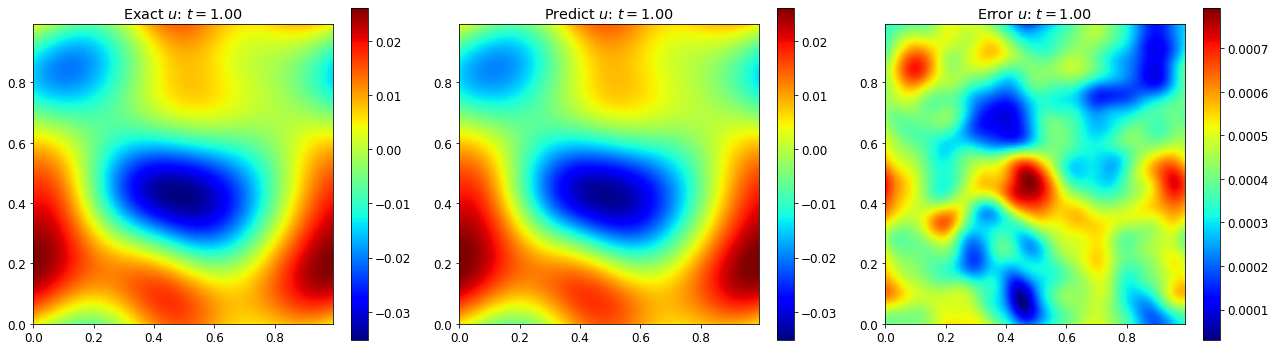

In [9]:
%matplotlib inline
movie_name = 'Burgers2D_coupled_u.gif'
frame_basename = 'Burgers2D_coupled_u_frame'
frame_ext = 'jpg'
plot_title = "$u$"
field = 0
val_cbar_index = -1
err_cbar_index = -1
font_size = 12
remove_frames = True

generate_movie_2D(key, test_x, test_y, preds_y, 
                  plot_title=plot_title, 
                  field=field, 
                  val_cbar_index=val_cbar_index, 
                  err_cbar_index=err_cbar_index, 
                  movie_dir=movie_dir, 
                  movie_name=movie_name, 
                  frame_basename=frame_basename, 
                  frame_ext=frame_ext, 
                  remove_frames=remove_frames, 
                  font_size=font_size)


### Movie $v$

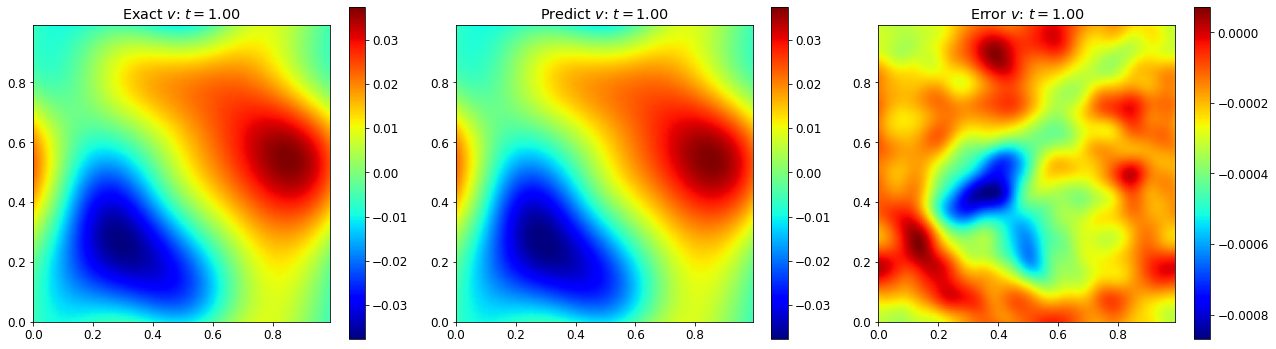

In [10]:
%matplotlib inline
movie_name = 'Burgers2D_coupled_v.gif'
frame_basename = 'Burgers2D_coupled_v_frame'
frame_ext = 'jpg'
plot_title = "$v$"
field = 1
val_cbar_index = -1
err_cbar_index = -1
font_size = 12
remove_frames = True

generate_movie_2D(key, test_x, test_y, preds_y, 
                  plot_title=plot_title, 
                  field=field, 
                  val_cbar_index=val_cbar_index, 
                  err_cbar_index=err_cbar_index, 
                  movie_dir=movie_dir, 
                  movie_name=movie_name, 
                  frame_basename=frame_basename, 
                  frame_ext=frame_ext, 
                  remove_frames=remove_frames, 
                  font_size=font_size)
